<a href="https://colab.research.google.com/github/oliahry/task_seb/blob/main/code_and_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Task for Junior Quantitative Analyst in Credit Risk Model Validation***

The first thing to do is load all nessecary libraries.

The libraries used in this project:

readr — for loading CSV files quickly and cleanly (read_csv).

dplyr — for data manipulation: filtering, joining tables, grouping, summarizing, creating new columns (filter, left_join, group_by, summarise, mutate).

tidyr — for data reshaping / tidying (missing handling helpers). In my script it is loaded mostly as part of a standard tidy workflow (not heavily used directly).

stringr — for string/text processing (cleaning text, pattern matching, extracting text). In your script it’s also loaded as a standard helper but not heavily used directly.

ggplot2 — for data visualization: line charts, bar charts, histograms, boxplots, faceting by year, etc.

scales — for formatting axes/labels in plots, especially percentages (percent_format) so PD/default-rate charts are easier to read.

I also called 2 helper functions (one to make decimals separated by . not , and the other to check key dublicates)

In [ ]:
suppressPackageStartupMessages({
  library(readr)
  library(dplyr)
  library(tidyr)
  library(stringr)
  library(ggplot2)
  library(scales)
})

# Helper: robust numeric conversion (handles comma decimals like "0,30394")
to_num <- function(x) {
  if (is.numeric(x)) return(x)
  as.numeric(str_replace_all(as.character(x), ",", "."))
}

# Helper: Primary-key duplicate check
pk_dups <- function(df, keys) {
  df %>% count(across(all_of(keys)), name = "n") %>% filter(n > 1)
}

Loaded the data to local environment of GoogleColab.

Then I read it using read_csv function.

In [ ]:
dat_arrangement <- read_csv("/content/dat_arrangement.csv", show_col_types = FALSE)
dat_obligor     <- read_csv("/content/dat_obligor.csv",     show_col_types = FALSE)
dat_scoring     <- read_csv("/content/dat_scoring.csv",     show_col_types = FALSE)
par_model       <- read_csv("/content/par_model.csv",       show_col_types = FALSE)
par_pools       <- read_csv("/content/par_pools.csv",       show_col_types = FALSE)

***Task 1***

*Visualize and provide a brief description on qualitative portfolio structure in terms of obligor, arrangement
and scoring features available, portfolio composition and performance. Assess consistency over
time.*

To start I verify whether tables respect their intended primary keys.

If these keys are not unique, joins may multiply rows and bias portfolio counts, default rates and later model evaluation.

In [ ]:
dup_arr <- pk_dups(dat_arrangement, c("AR_ID","YEAR"))           # arrangement PK
dup_obl <- pk_dups(dat_obligor,     c("IP_ID","YEAR"))           # obligor PK
dup_scr <- pk_dups(dat_scoring,     c("AR_ID","IP_ID","YEAR"))   # scoring PK

cat("PK duplicates:\n")
cat("  dat_arrangement (AR_ID,YEAR):", nrow(dup_arr), "\n")
cat("  dat_obligor     (IP_ID,YEAR):", nrow(dup_obl), "\n")
cat("  dat_scoring     (AR_ID,IP_ID,YEAR):", nrow(dup_scr), "\n")

PK duplicates:
  dat_arrangement (AR_ID,YEAR): 1536 
  dat_obligor     (IP_ID,YEAR): 0 
  dat_scoring     (AR_ID,IP_ID,YEAR): 0 


As it is shown there are dublicates in dat_arrangements. Before moving forward I would delete those dublicates for cleaner and more accurate visualization of datset.

In [ ]:
dat_arrangement_clean <- dat_arrangement %>% distinct()

cat("Rows dat_arrangement before:", nrow(dat_arrangement), "\n")
cat("Rows dat_arrangement after distinct():", nrow(dat_arrangement_clean), "\n")

Rows dat_arrangement before: 35820 
Rows dat_arrangement after distinct(): 34949 


Now I combine scoring output with arrangement-level and obligor-level raw risk attributes into one table for descriptive analysis and later do model checks.

Joins scoring + arrangement + obligor into one analysis table (ABT).
Converts key fields to numeric/integer formats for analysis.

In [ ]:
abt <- dat_scoring %>%
  left_join(dat_arrangement_clean, by = c("AR_ID" = "AR_ID", "YEAR" = "YEAR")) %>%
  left_join(dat_obligor,           by = c("IP_ID" = "IP_ID", "YEAR" = "YEAR")) %>%
  mutate(
    year = as.integer(YEAR),
    dflt_flag = as.integer(DFLT_FLAG),
    pd = to_num(PD),
    pd_pool = as.character(PD_POOL),

    # Raw predictors converted to numeric where needed
    age = suppressWarnings(to_num(AGE)),
    education = suppressWarnings(as.integer(EDUCATION)),
    debt_ratio = to_num(DEBT_RATIO),
    dpd = to_num(DPD),
    m_last_dpd = to_num(M_LAST_DPD)
  )

To check if the join worked correctly I check how many rows were in data_scoring and in new joined table.

In [ ]:

cat("Rows dat_scoring:", nrow(dat_scoring), "\n")
cat("Rows abt       :", nrow(abt), "\n")

Rows dat_scoring: 36000 
Rows abt       : 36687 


The join did not work corectly as joined table has more rows then the starting one. This is because not all duclicates were deleted with distinct() function before joining the tables. So we need to check which join failed by showing rows after each join.

In [ ]:
# Baseline
n_sc <- nrow(dat_scoring)

# After joining arrangement only
tmp1 <- dat_scoring %>% left_join(dat_arrangement_clean, by = c("AR_ID","YEAR"))

# After joining obligor as well
tmp2 <- tmp1 %>% left_join(dat_obligor, by = c("IP_ID","YEAR"))

cat("Rows scoring:", n_sc, "\n")
cat("After arrangement join:", nrow(tmp1), " (+", nrow(tmp1)-n_sc, ")\n")
cat("After obligor join:", nrow(tmp2), " (+", nrow(tmp2)-n_sc, ")\n")

Rows scoring: 36000 
After arrangement join: 36687  (+ 687 )
After obligor join: 36687  (+ 687 )


As expected the join failed on joining data_arrangement_clean. So we must delete dublicates more thoroughly.

I kept only one row per key in dat_arrangement table with most filled in data.

In [ ]:
dat_arrangement <- dat_arrangement_clean %>%
  mutate(non_na = rowSums(!is.na(across(everything())))) %>%
  arrange(AR_ID, YEAR, desc(non_na)) %>%
  group_by(AR_ID, YEAR) %>%
  slice(1) %>%
  ungroup() %>%
  select(-non_na)

After that I rebuild ABT using de-duplicated one-row-per-key tables.

This should eliminate row multiplication caused by duplicate join keys.

In [ ]:
abt <- dat_scoring %>%
  left_join(dat_arrangement, by = c("AR_ID","YEAR")) %>%
  left_join(dat_obligor,     by = c("IP_ID","YEAR")) %>%
  mutate(
    year = as.integer(YEAR),
    dflt_flag = as.integer(DFLT_FLAG),
    pd = to_num(PD),
    pd_pool = as.character(PD_POOL),
    age = suppressWarnings(to_num(AGE)),
    education = suppressWarnings(as.integer(EDUCATION)),
    debt_ratio = to_num(DEBT_RATIO),
    dpd = to_num(DPD),
    m_last_dpd = to_num(M_LAST_DPD)
  )

cat("Rows dat_scoring:", nrow(dat_scoring), "\n")
cat("Rows abt        :", nrow(abt), "\n")

Rows dat_scoring: 36000 
Rows abt        : 36000 


As it is shown the dublication was solved so I move to next step of the task.

Basic ABT statistics to confirm joins worked:


In [ ]:
cat("ABT rows:", nrow(abt), "\n")
cat("Unique arrangements:", n_distinct(abt$AR_ID), "\n")
cat("Unique obligors:", n_distinct(abt$IP_ID), "\n")
cat("Years in ABT:", paste(sort(unique(abt$year)), collapse = ", "), "\n\n")

ABT rows: 36000 
Unique arrangements: 16800 
Unique obligors: 14000 
Years in ABT: 2022, 2023, 2024 



Summary of the portfolio size and performance by year:

In [ ]:
size_year <- abt %>%
  group_by(year) %>%
  summarise(
    n_arrangements = n(),
    n_obligors = n_distinct(IP_ID),
    default_rate = mean(dflt_flag, na.rm = TRUE),
    avg_pd = mean(pd, na.rm = TRUE),
    .groups = "drop"
  )

print(size_year)

# A tibble: 3 × 5
   year n_arrangements n_obligors default_rate avg_pd
  <int>          <int>      <int>        <dbl>  <dbl>
1  2022          12000      10524        0.127 0.0826
2  2023          12000      10537        0.124 0.123 
3  2024          12000      10531        0.346 0.231 


Visualizations of yearly portfolio size and risk/performance trends:

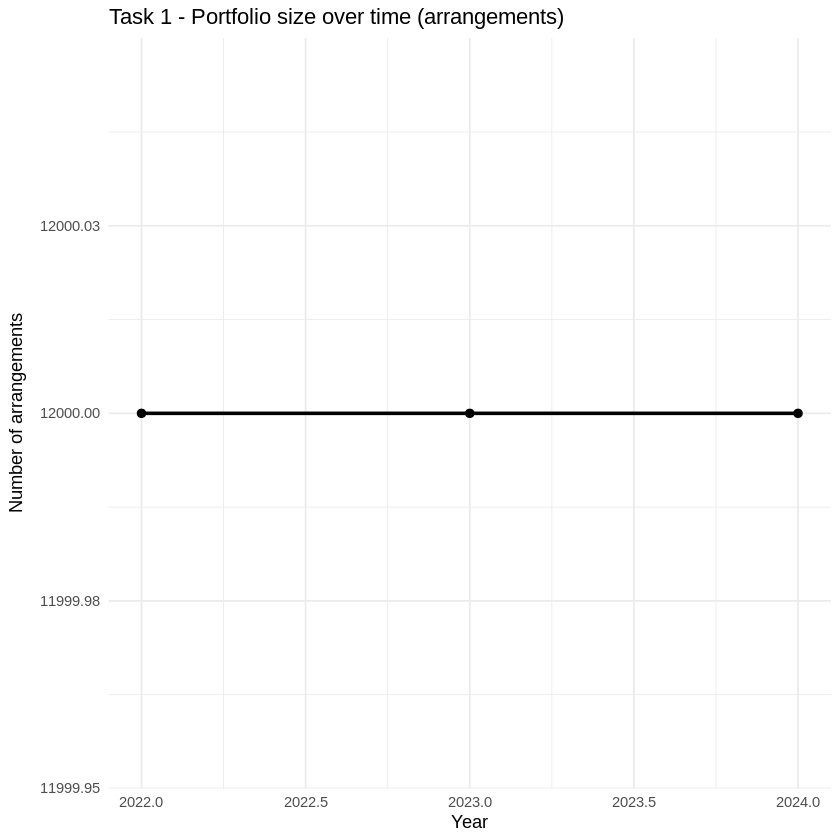

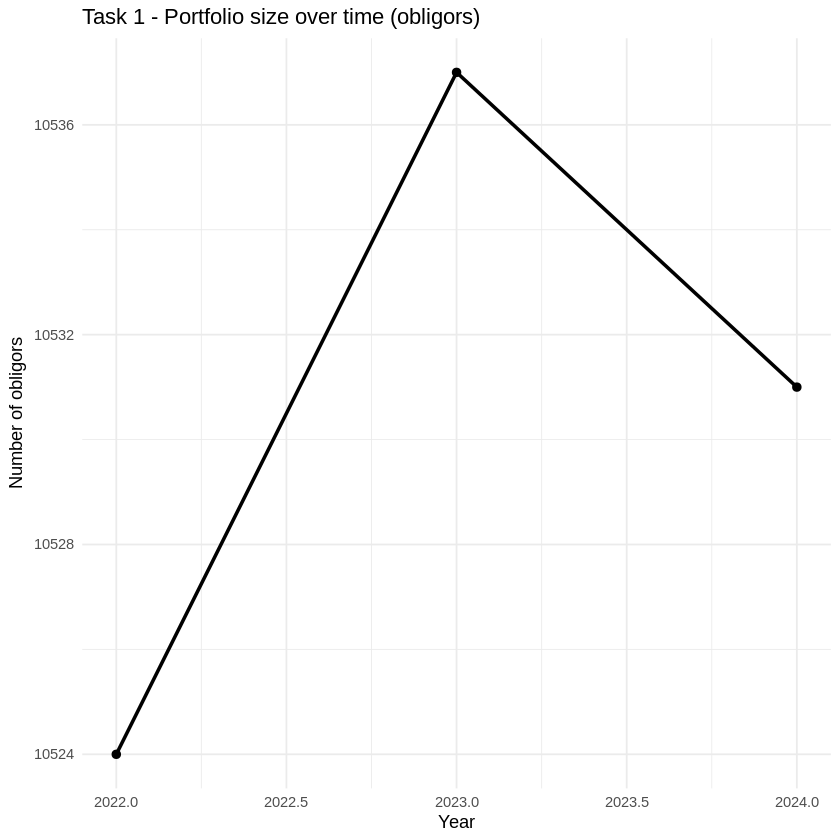

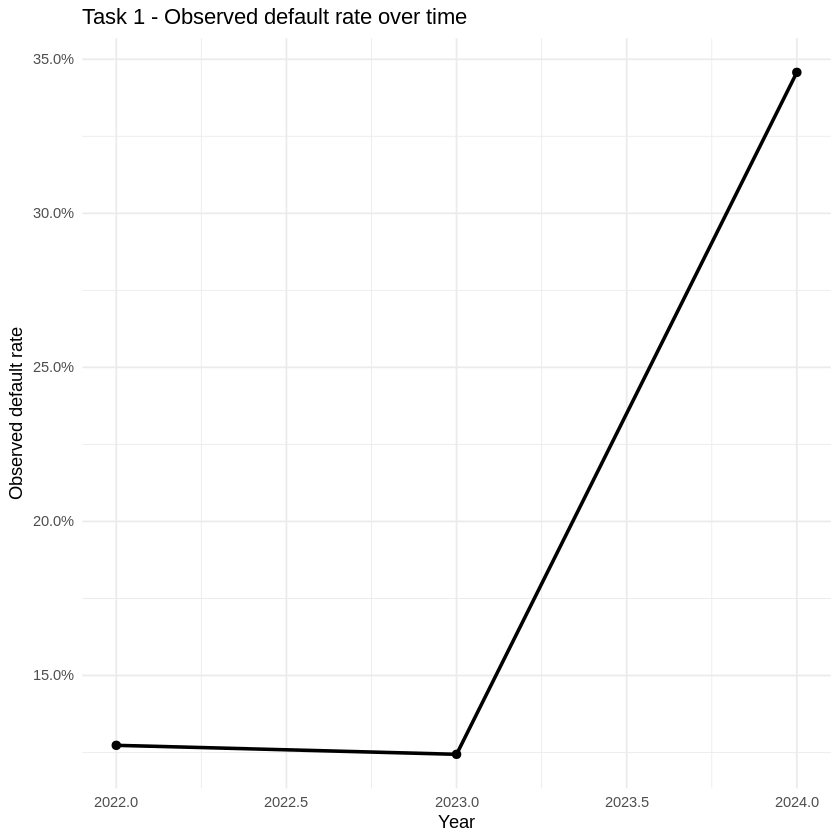

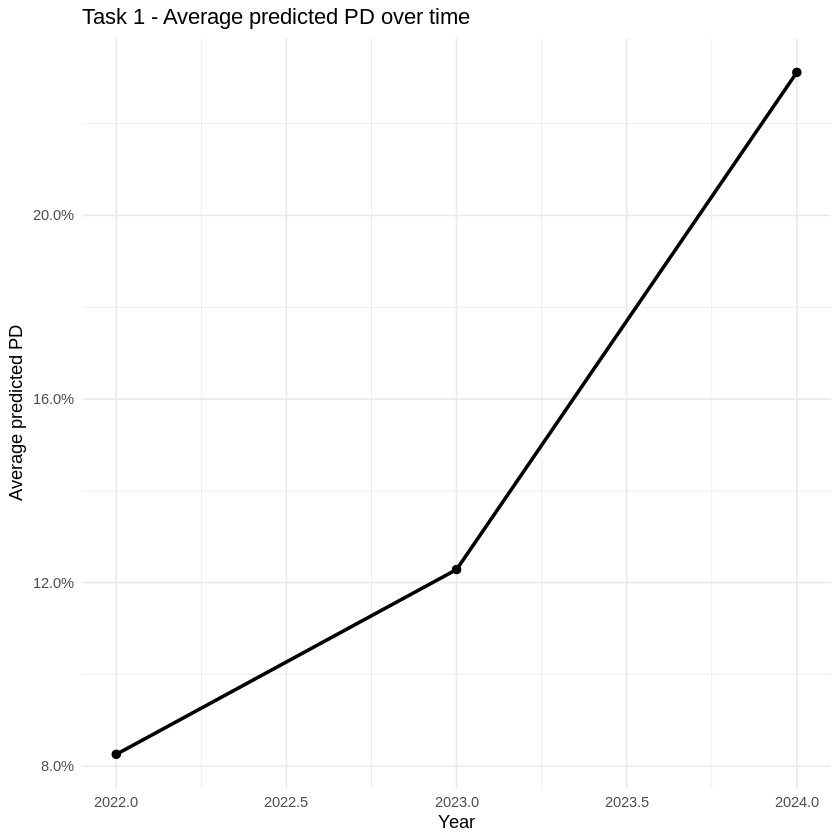

In [ ]:
ggplot(size_year, aes(x = year, y = n_arrangements)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  labs(
    title = "Task 1 - Portfolio size over time (arrangements)",
    x = "Year", y = "Number of arrangements"
  ) +
  theme_minimal()

ggplot(size_year, aes(x = year, y = n_obligors)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  labs(
    title = "Task 1 - Portfolio size over time (obligors)",
    x = "Year", y = "Number of obligors"
  ) +
  theme_minimal()

ggplot(size_year, aes(x = year, y = default_rate)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 1 - Observed default rate over time",
    x = "Year", y = "Observed default rate"
  ) +
  theme_minimal()

ggplot(size_year, aes(x = year, y = avg_pd)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 1 - Average predicted PD over time",
    x = "Year", y = "Average predicted PD"
  ) +
  theme_minimal()

The number of arrangements is perfectly stable across 2022–2024 at 12,000 each year, so there is no year-to-year change in portfolio size at arrangement level. The number of obligors is also very stable, with only a small increase in 2023 and a slight decrease in 2024, meaning the portfolio composition changes only marginally over time.

In contrast, risk performance changes materially. The observed default rate is broadly stable in 2022–2023 at around 12–13%, but then rises sharply to about 34–35% in 2024, indicating a substantial deterioration in realised credit quality. The average predicted PD also increases over time, from roughly 8% in 2022 to 12% in 2023 and around 22–23% in 2024, which shows that the model captures the direction of worsening risk.

However, in 2024 the increase in predicted PD is still noticeably smaller than the increase in the observed default rate. This suggests that although the model remains directionally responsive, it may underpredict risk in 2024 and therefore show signs of weaker calibration in the most recent year.

Summary of portfolio composition by PD pool and year:

year — reporting year

pd_pool — risk pool (1 = lowest risk, 5 = highest risk, NA = no pool assigned)

n — number of observations in that pool

dr — observed default rate in that pool

avg_pd — average predicted PD in that pool

share — share of total portfolio in that pool for that year

In [ ]:
pool_year <- abt %>%
  group_by(year, pd_pool) %>%
  summarise(
    n = n(),
    dr = mean(dflt_flag, na.rm = TRUE),
    avg_pd = mean(pd, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  group_by(year) %>%
  mutate(share = n / sum(n)) %>%
  ungroup()

print(pool_year)

# A tibble: 18 × 6
    year pd_pool     n      dr       avg_pd    share
   <int> <chr>   <int>   <dbl>        <dbl>    <dbl>
 1  2022 1       10262 0.00516   0.00000351 0.855   
 2  2022 2           7 0.429     0.00185    0.000583
 3  2022 3          10 1         0.00586    0.000833
 4  2022 4          60 0.967     0.0289     0.005   
 5  2022 5        1375 0.997     0.702      0.115   
 6  2022 NA        286 0.115   NaN          0.0238  
 7  2023 1        3386 0.00266   0.000425   0.282   
 8  2023 2        2816 0.00355   0.00160    0.235   
 9  2023 3        2535 0.00868   0.00547    0.211   
10  2023 4        1539 0.0175    0.0166     0.128   
11  2023 5        1421 0.978     0.979      0.118   
12  2023 NA        303 0.116   NaN          0.0253  
13  2024 1        3136 0.147     0.000428   0.261   
14  2024 2        2349 0.159     0.00156    0.196   
15  2024 3        2179 0.146     0.00557    0.182   
16  2024 4        1341 0.164     0.0167     0.112   
17  2024 5        2689 0.99

The pool_year results show a clear worsening in portfolio risk composition over time. In 2022, the portfolio is heavily concentrated in Pool 1 (85.5%), while in 2023–2024 the distribution becomes much more spread across all pools and the share of Pool 5 increases to 22.4% in 2024. This indicates a shift toward a riskier portfolio structure and is consistent with the rise in both the observed default rate and the average predicted PD.

Pool-level default rates generally confirm risk differentiation: Pool 1 remains the lowest-risk group, while Pool 5 is consistently the highest-risk group. However, the ordering is not fully monotonic in the middle pools (2–4), which may reflect sample composition or volatility. In addition, around 2.4–2.6% of observations have missing PD pool assignment, which should be noted as a data quality issue.

Visualization of the PD pool portfolio shares and pool-level default rates by year:

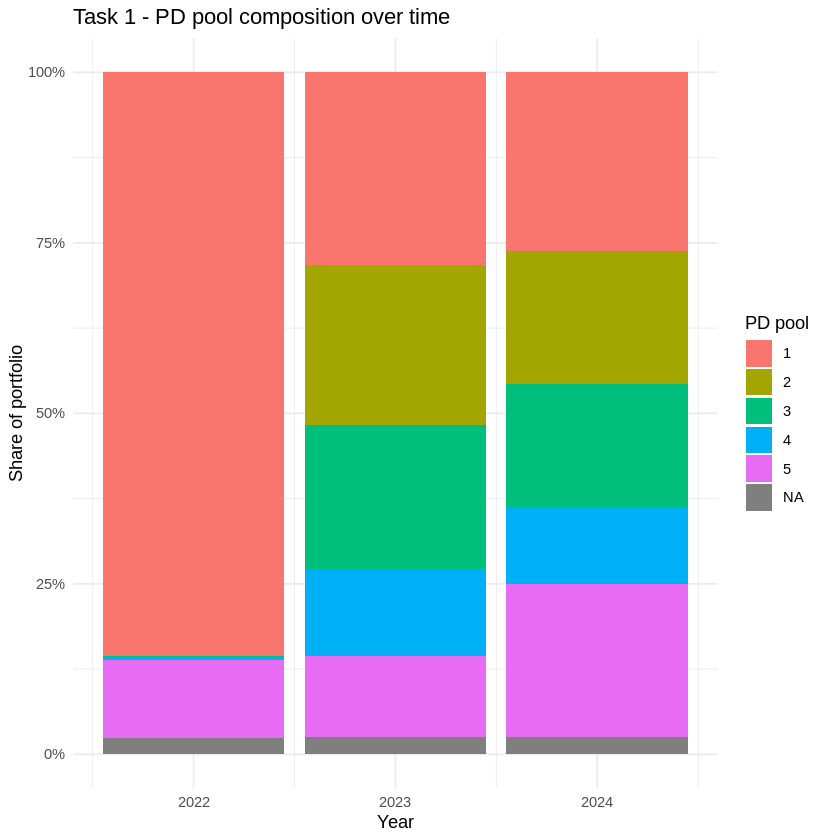

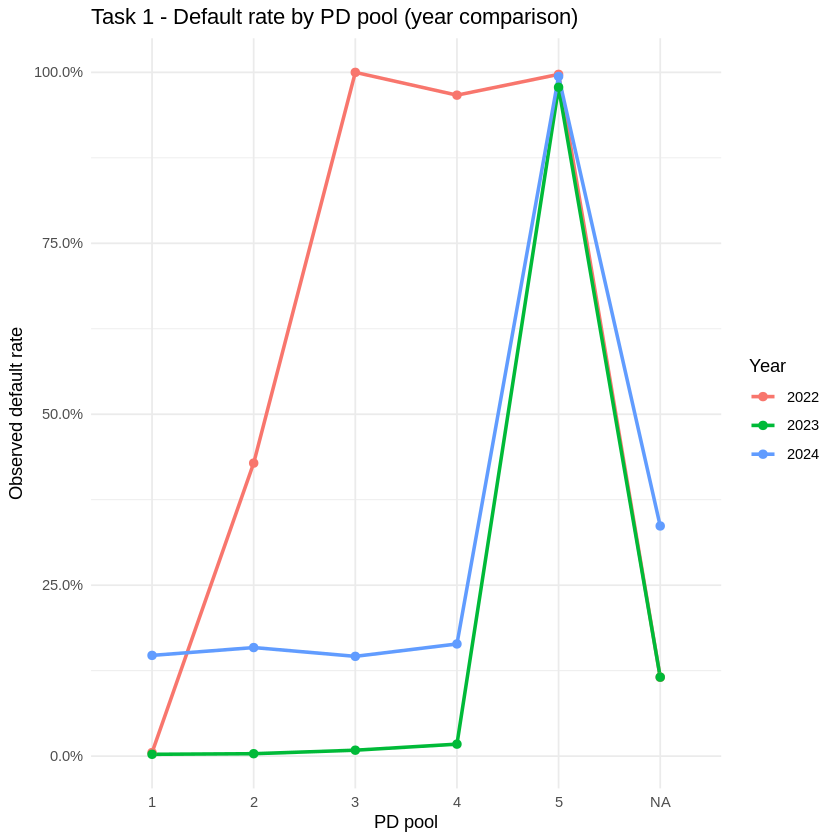

In [ ]:
ggplot(pool_year, aes(x = year, y = share, fill = pd_pool)) +
  geom_col() +
  scale_y_continuous(labels = percent_format()) +
  labs(
    title = "Task 1 - PD pool composition over time",
    x = "Year", y = "Share of portfolio", fill = "PD pool"
  ) +
  theme_minimal()

ggplot(pool_year, aes(x = pd_pool, y = dr, group = factor(year), color = factor(year))) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 1 - Default rate by PD pool (year comparison)",
    x = "PD pool", y = "Observed default rate", color = "Year"
  ) +
  theme_minimal()

These two plots confirm the key story from your pool_year table: the portfolio risk mix changes a lot over time, and the pools provide broad risk separation, especially for the highest-risk pool.
The PD pool composition plot shows a strong shift in portfolio structure across 2022 - 2024. In 2022, the portfolio is heavily concentrated in the lowest-risk pool, while in 2023 - 2024 the distribution becomes more spread out and the share of high-risk pools increases substantially. This indicates clear composition drift toward higher-risk exposures. The pool default-rate comparison plot confirms that the PD pools provide meaningful risk differentiation overall: Pool 1 remains low-risk and Pool 5 consistently has the highest observed default rate. Although monotonicity is not perfect across middle pools, especially due to sample-size effects and yearly variation, the segmentation is still informative and consistent with the increase in overall default rate observed in 2024.

Yearly education composition table (shares):

n = number of observations in each education group

share = share of that education group in the yearly portfolio

Includes an NA group (missing education)

In [ ]:
edu_year <- abt %>%
  mutate(
    education_lbl = factor(
      education,
      levels = c(1, 2, 3),
      labels = c("Education 1", "Education 2", "Education 3")
    )
  ) %>%
  group_by(year, education_lbl) %>%
  summarise(n = n(), .groups = "drop") %>%
  group_by(year) %>%
  mutate(share = n / sum(n)) %>%
  ungroup()

print(edu_year)

# A tibble: 12 × 4
    year education_lbl     n share
   <int> <fct>         <int> <dbl>
 1  2022 Education 1    3714 0.310
 2  2022 Education 2    1883 0.157
 3  2022 Education 3    4886 0.407
 4  2022 NA             1517 0.126
 5  2023 Education 1    3045 0.254
 6  2023 Education 2    2204 0.184
 7  2023 Education 3    5264 0.439
 8  2023 NA             1487 0.124
 9  2024 Education 1    2627 0.219
10  2024 Education 2    2355 0.196
11  2024 Education 3    5598 0.466
12  2024 NA             1420 0.118


The education composition analysis indicates moderate portfolio profile drift over 2022 - 2024. Education 3 is the largest group in all years and increases steadily (40.7% to 43.9% to 46.6%), while Education 1 decreases (31.0% to 25.4% to 21.9%) and Education 2 increases slightly (15.7% to 18.4% to 19.6%). The share of missing education remains stable at around 11-12%, which is material and suggests that missing-value treatment for this predictor is important for model application and monitoring.

Visualization of education composition by year.

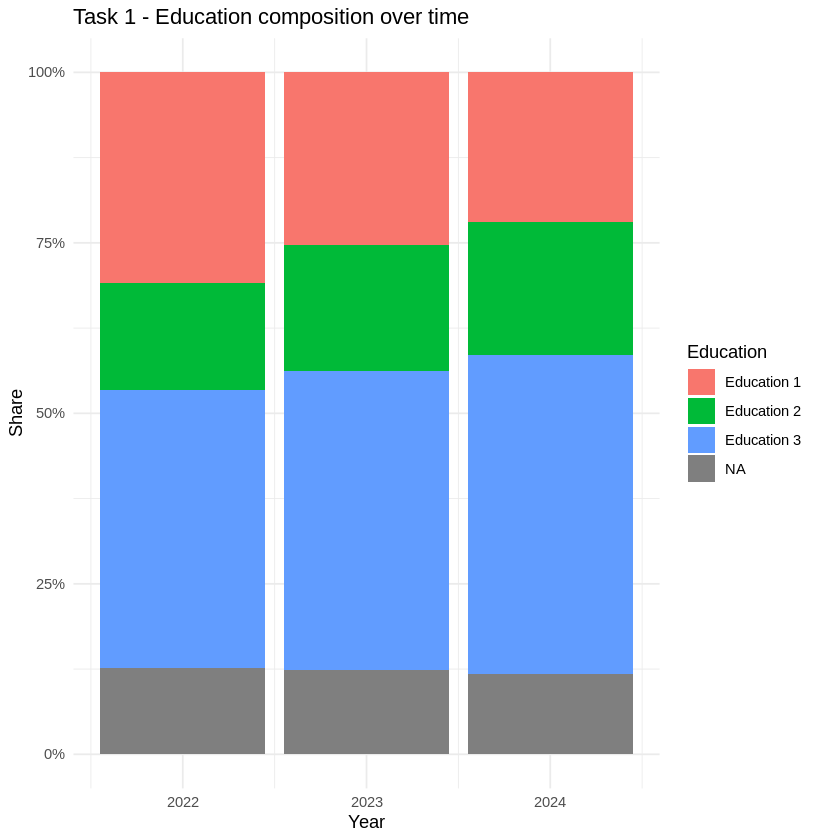

In [ ]:
ggplot(edu_year, aes(x = year, y = share, fill = education_lbl)) +
  geom_col() +
  scale_y_continuous(labels = percent_format()) +
  labs(
    title = "Task 1 - Education composition over time",
    x = "Year", y = "Share", fill = "Education"
  ) +
  theme_minimal()

The education composition plot confirms moderate but consistent profile drift over 2022 - 2024. While the overall portfolio structure remains broadly similar, the share of Education 3 increases steadily, Education 1 decreases, and Education 2 increases slightly. The share of missing education remains stable at around 12%. This indicates gradual changes in borrower characteristics over time and suggests that predictor distribution drift should be considered when interpreting score behavior and model performance trends.

Distributions of important predictors by year:

Warning message:
“Removed 4271 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2200 rows containing non-finite outside the scale range (`stat_bin()`).”


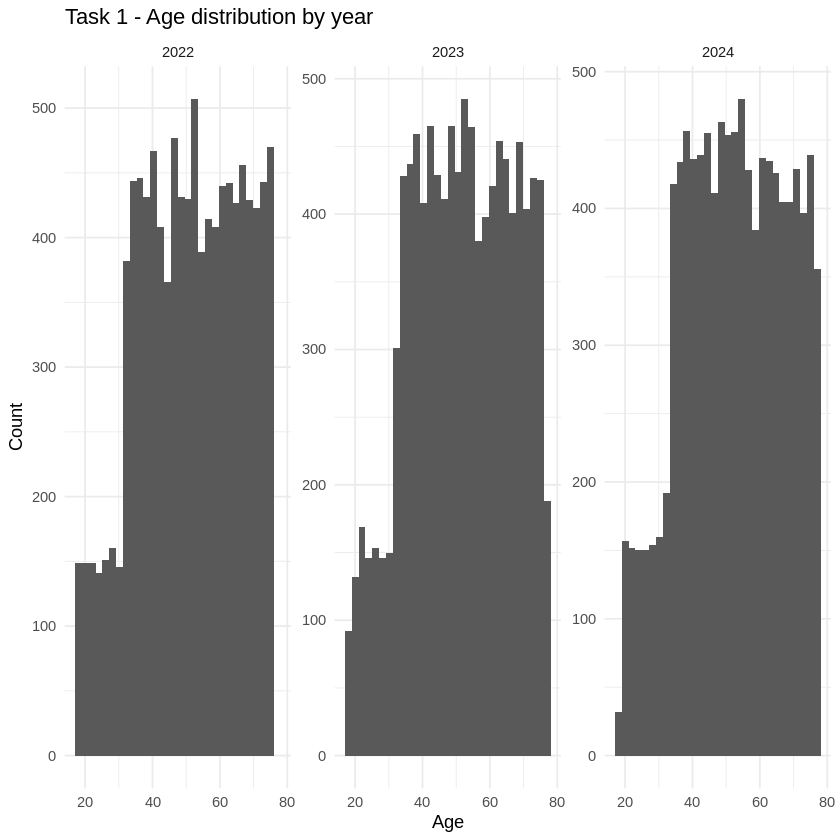

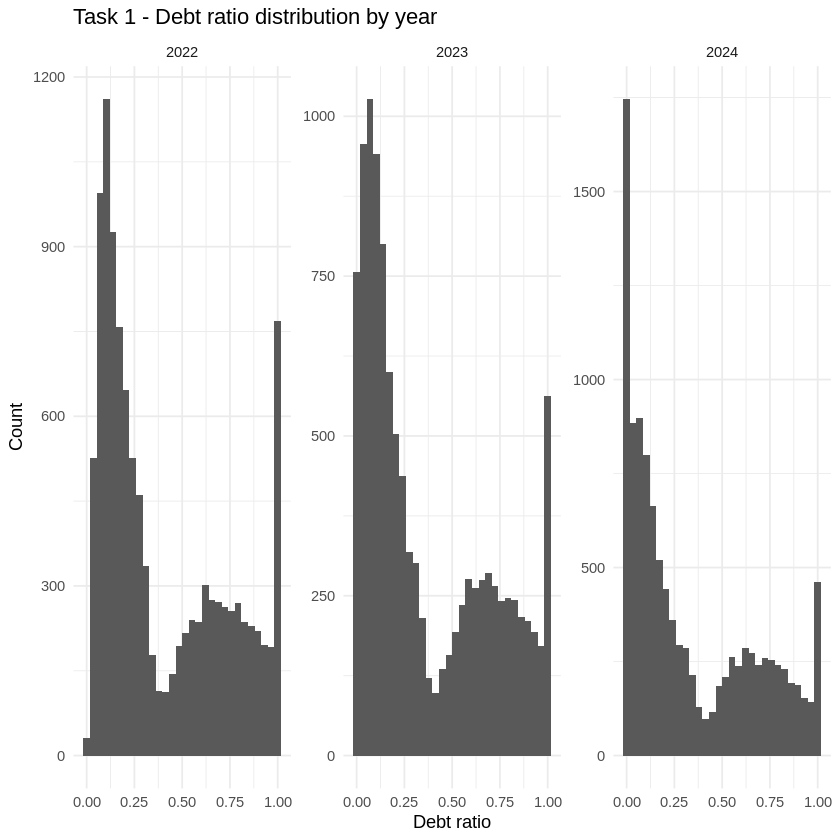

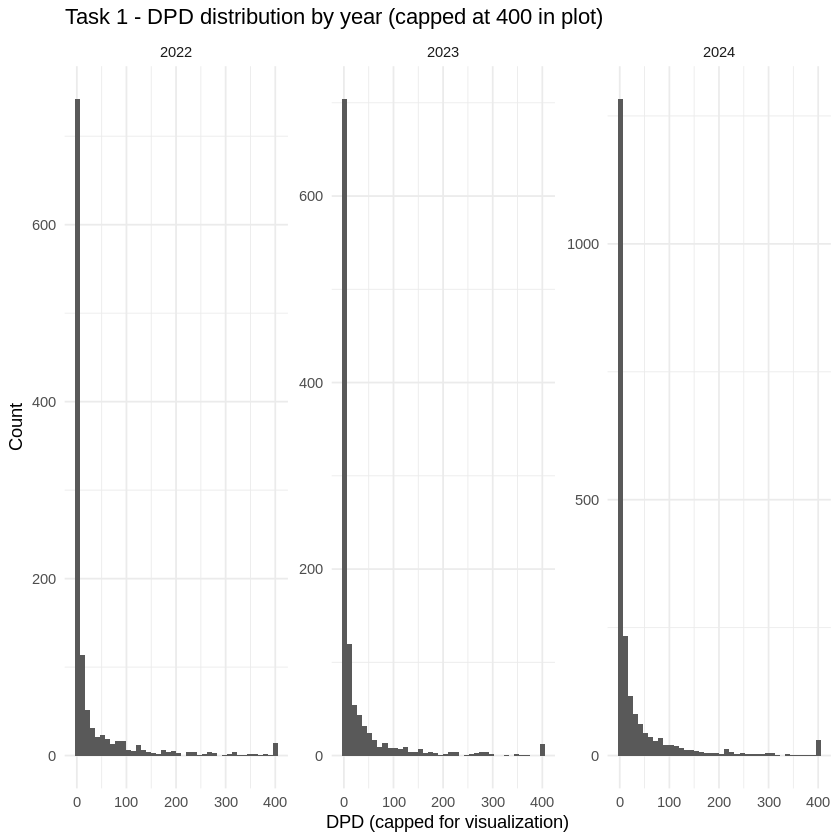

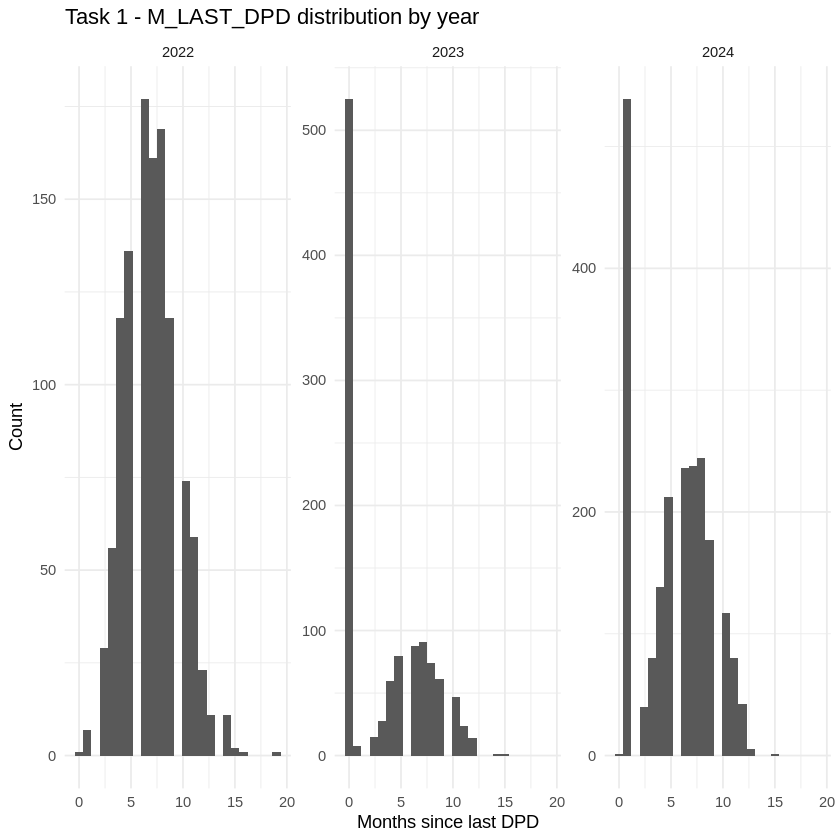

In [ ]:
ggplot(abt, aes(x = age)) +
  geom_histogram(bins = 30) +
  facet_wrap(~year, scales = "free_y") +
  labs(
    title = "Task 1 - Age distribution by year",
    x = "Age", y = "Count"
  ) +
  theme_minimal()

ggplot(abt, aes(x = debt_ratio)) +
  geom_histogram(bins = 30) +
  facet_wrap(~year, scales = "free_y") +
  labs(
    title = "Task 1 - Debt ratio distribution by year",
    x = "Debt ratio", y = "Count"
  ) +
  theme_minimal()

ggplot(abt %>% filter(!is.na(dpd)), aes(x = pmin(dpd, 400))) +
  geom_histogram(bins = 40) +
  facet_wrap(~year, scales = "free_y") +
  labs(
    title = "Task 1 - DPD distribution by year (capped at 400 in plot)",
    x = "DPD (capped for visualization)", y = "Count"
  ) +
  theme_minimal()

ggplot(abt %>% filter(!is.na(m_last_dpd)), aes(x = m_last_dpd)) +
  geom_histogram(bins = 25) +
  facet_wrap(~year, scales = "free_y") +
  labs(
    title = "Task 1 - M_LAST_DPD distribution by year",
    x = "Months since last DPD", y = "Count"
  ) +
  theme_minimal()

The predictor distribution histograms indicate mixed stability across variables. Age appears broadly stable over time, with similar shapes across 2022 - 2024, suggesting limited drift in this predictor. In contrast, debt ratio and DPD show stronger skewness and more noticeable distribution changes, with DPD remaining heavily right-skewed and concentrated near zero in all years (with a long tail of high values). M_LAST_DPD is more concentrated and comparatively stable, although the spike at zero suggests some change in recent delinquency timing patterns. Overall, the histograms provide evidence of predictor distribution drift, particularly for risk-related behavioral variables, which may contribute to changes in score distribution, calibration, and observed default rates over time. Missing/non-finite values were excluded from the histograms, as indicated by ggplot warnings, which is consistent with the data quality findings.

Calibration plot and table:

It clearly shows how model predictions compare with realized defaults over time.

avg_pd = average predicted PD (model expectation)

default_rate = observed default rate (realized outcome)

pd_minus_dr = avg_pd - default_rate = calibration gap at portfolio level


# A tibble: 3 × 4
   year avg_pd default_rate pd_minus_dr
  <int>  <dbl>        <dbl>       <dbl>
1  2022 0.0826        0.127    -0.0447 
2  2023 0.123         0.124    -0.00156
3  2024 0.231         0.346    -0.115  


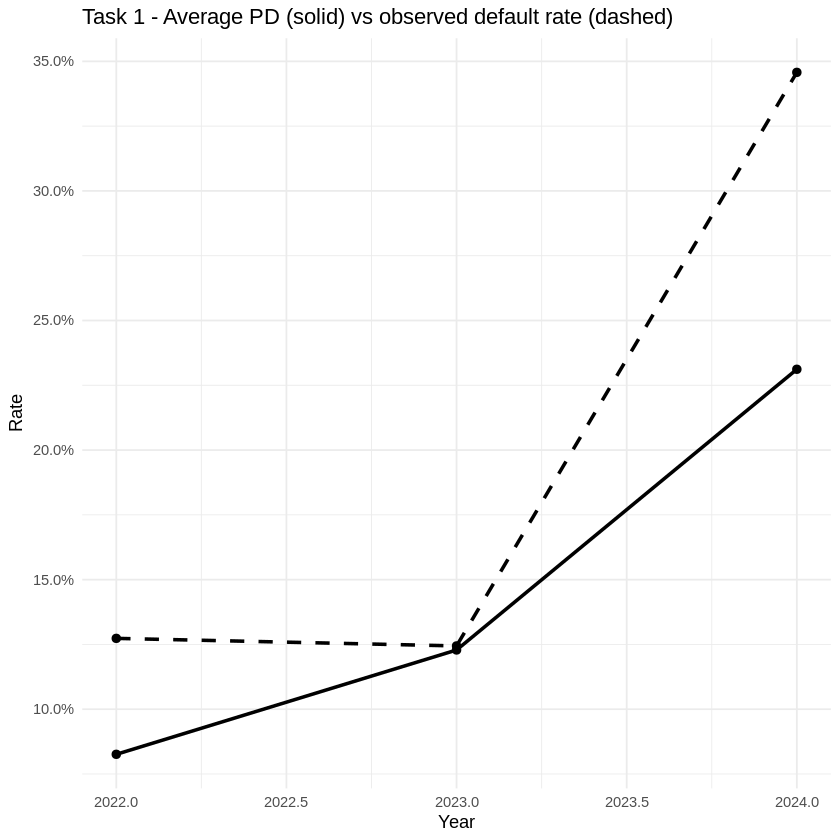

In [ ]:
cal_year <- abt %>%
  group_by(year) %>%
  summarise(
    avg_pd = mean(pd, na.rm = TRUE),
    default_rate = mean(dflt_flag, na.rm = TRUE),
    pd_minus_dr = avg_pd - default_rate,
    .groups = "drop"
  )

print(cal_year)

ggplot(cal_year, aes(x = year)) +
  geom_line(aes(y = avg_pd), linewidth = 1) +
  geom_point(aes(y = avg_pd), size = 2) +
  geom_line(aes(y = default_rate), linewidth = 1, linetype = "dashed") +
  geom_point(aes(y = default_rate), size = 2) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 1 - Average PD (solid) vs observed default rate (dashed)",
    x = "Year", y = "Rate"
  ) +
  theme_minimal()

The portfolio-level calibration comparison shows that average predicted PD and observed default rate move in the same direction over time, but the model underpredicts realized default risk in 2022 and especially in 2024. In 2023, the model is almost perfectly calibrated at the aggregate level (12.3% predicted vs 12.4% observed). In contrast, 2024 shows a substantial calibration gap (23.1% predicted vs 34.6% observed), indicating that the model captures worsening risk conditions but materially underestimates the severity of realized defaults.

**Conclusions of Task 1**

The portfolio size is highly stable over time at the arrangement level: the number of arrangements remains constant at 12,000 in each year from 2022 to 2024. The number of obligors is also broadly stable, with only minor year-to-year variation. This indicates that the overall portfolio size does not change materially over the observed period.

In contrast, portfolio risk performance changes substantially. The observed default rate is broadly stable in 2022–2023 at around 12–13%, but rises sharply to approximately 34.6% in 2024, indicating a clear deterioration in realised credit quality. The average predicted Probability of Default (PD) also increases over time, from about 8.3% in 2022 to 12.3% in 2023 and 23.1% in 2024, which shows that the model captures the direction of worsening risk. However, the increase in predicted PD is smaller than the increase in observed defaults, which already suggests weaker calibration in the most recent year.

The portfolio risk mix also worsens over time. In 2022, the portfolio is heavily concentrated in the lowest-risk PD pool 1 (about 85.5% of observations), whereas in 2023–2024 the distribution becomes much more dispersed and the share of the highest-risk pool 5 rises materially, reaching 22.4% in 2024. This indicates a shift from a predominantly low-risk portfolio structure in 2022 to a materially riskier portfolio in later years.

Overall, results show a portfolio that is stable in size but not in risk composition or performance. The key conclusion is that portfolio risk increases strongly over time, especially in 2024, and that this change is visible both in realised defaults and in the distribution of predicted risk.

***Task 2***

*Provide opinion on data quality in terms of completeness, accuracy, consistency*

Before starting Task 2 I would like to remind that dat_arrangement dataset was cleaned of dublicated rows already in Task 1.

So then I created a helper function for missing-value reporting.

Computed missingness for each source table.

missing_n = how many values are missing

missing_pct = % of rows missing in that column

In [ ]:
missing_report <- function(df, table_name) {
  tibble(
    table = table_name,
    column = names(df),
    missing_n = sapply(df, function(x) sum(is.na(x))),
    missing_pct = round(100 * missing_n / nrow(df), 2)
  ) %>%
    arrange(desc(missing_pct))
}

cat("Task 2 / Completeness: Missingness\n")
missing_arr <- missing_report(dat_arrangement, "dat_arrangement")
missing_obl <- missing_report(dat_obligor, "dat_obligor")
missing_sco <- missing_report(dat_scoring, "dat_scoring")

print(missing_arr)
print(missing_obl)
print(missing_sco)

Task 2 / Completeness: Missingness
# A tibble: 5 × 4
  table           column     missing_n missing_pct
  <chr>           <chr>          <int>       <dbl>
1 dat_arrangement DPD            29841       87.1 
2 dat_arrangement M_LAST_DPD     29841       87.1 
3 dat_arrangement DEBT_RATIO       462        1.35
4 dat_arrangement AR_ID              0        0   
5 dat_arrangement YEAR               0        0   
# A tibble: 4 × 4
  table       column    missing_n missing_pct
  <chr>       <chr>         <int>       <dbl>
1 dat_obligor EDUCATION       789        2.5 
2 dat_obligor AGE             334        1.06
3 dat_obligor IP_ID             0        0   
4 dat_obligor YEAR              0        0   
# A tibble: 6 × 4
  table       column    missing_n missing_pct
  <chr>       <chr>         <int>       <dbl>
1 dat_scoring PD              895        2.49
2 dat_scoring PD_POOL         895        2.49
3 dat_scoring YEAR              0        0   
4 dat_scoring IP_ID             0        0   
5 

The completeness assessment shows that identifier and key linkage fields (AR_ID, IP_ID, YEAR) are fully populated across all source tables, which supports reliable joining and record matching. The main completeness issue is in dat_arrangement, where DPD and M_LAST_DPD are missing for 87.1% of records, indicating that these variables are only available for a subset of observations or are structurally sparse. Additional input variables show smaller but relevant missingness (DEBT_RATIO 1.35%, EDUCATION 2.5%, AGE 1.06%). In the scoring output table, PD and PD_POOL are both missing for 2.49% of records, which represents a scoring completeness issue and requires exclusion or special handling in model performance analyses.

Next I show that no more dublicates are in any of the datasets:

dat_arrangement should be unique by (AR_ID, YEAR)

dat_obligor should be unique by (IP_ID, YEAR)

dat_scoring should be unique by (YEAR, IP_ID, AR_ID)

It is important to check and delete duplicates because if they exist, it can cause:

duplicate rows after joins,
incorrect counts,
biased averages/default rates,
wrong model validation results.

In [ ]:
dup_arr <- dat_arrangement %>% count(AR_ID, YEAR) %>% filter(n > 1)
dup_obl <- dat_obligor %>% count(IP_ID, YEAR) %>% filter(n > 1)
dup_sco <- dat_scoring %>% count(YEAR, IP_ID, AR_ID) %>% filter(n > 1)

cat("\n Task 2 / PK duplicate checks\n")
cat("dat_arrangement duplicate PK rows:", nrow(dup_arr), "\n")
cat("dat_obligor duplicate PK rows:", nrow(dup_obl), "\n")
cat("dat_scoring duplicate PK rows:", nrow(dup_sco), "\n")


 Task 2 / PK duplicate checks
dat_arrangement duplicate PK rows: 0 
dat_obligor duplicate PK rows: 0 
dat_scoring duplicate PK rows: 0 


dat_arrangement has no more dublicates (before was 1,536) (AR_ID, YEAR) key combinations due to data cleaning that I performed at the start, while dat_obligor and dat_scoring have no PK duplicates at all. This is critical because duplicates in dat_arrangement can duplicate rows after joins and distort all downstream analyses.

Next I checked if all records from dat_scorring have keys that match from dat_arrangement and dat_obligor.

In [ ]:
abt_keys <- dat_scoring %>%
  left_join(dat_arrangement %>% select(AR_ID, YEAR) %>% mutate(has_arr = TRUE),
            by = c("AR_ID", "YEAR")) %>%
  left_join(dat_obligor %>% select(IP_ID, YEAR) %>% mutate(has_obl = TRUE),
            by = c("IP_ID", "YEAR")) %>%
  mutate(
    has_arr = ifelse(is.na(has_arr), FALSE, has_arr),
    has_obl = ifelse(is.na(has_obl), FALSE, has_obl)
  )

cat("\n Task 2 / Referential consistency\n")
cat("Scoring rows without matching arrangement:", sum(!abt_keys$has_arr), "\n")
cat("Scoring rows without matching obligor:", sum(!abt_keys$has_obl), "\n")


 Task 2 / Referential consistency
Scoring rows without matching arrangement: 1738 
Scoring rows without matching obligor: 3604 


The referential consistency check shows that not all scoring records can be matched to the supporting source tables. Specifically, 1,738 scoring rows do not have a matching arrangement record, and 3,604 scoring rows do not have a matching obligor record. This indicates incomplete linkage between the tables, with the issue being more severe for obligor data. As a result, some scoring observations cannot be fully enriched with arrangement- or obligor-level attributes, which should be flagged as a data quality issue and may affect the completeness of the ABT and any downstream analysis.

Now I want to do checks whether key fields follow expected format, range, and coding rules from the task description / data dictionary.

In [ ]:
# YEAR valididty
year_check <- dat_scoring %>%
  mutate(year_num = suppressWarnings(as.integer(YEAR))) %>%
  summarise(
    min_year = min(year_num, na.rm = TRUE),
    max_year = max(year_num, na.rm = TRUE),
    n_missing_year = sum(is.na(year_num)),
    n_invalid_year = sum(!(year_num %in% c(2022, 2023, 2024)), na.rm = TRUE)
  )

# AR_ID format validity
# Rule: must consist of exactly 8 digits
ar_id_check <- dat_scoring %>%
  mutate(ar_id_ok = str_detect(as.character(AR_ID), "^\\d{8}$")) %>%
  summarise(
    n_missing = sum(is.na(AR_ID)),
    n_invalid = sum(!is.na(AR_ID) & !ar_id_ok),
    invalid_pct = mean(!is.na(AR_ID) & !ar_id_ok)
  )

# IP_ID format validity
# Rule: must consist of 3 letters + 3 digits
ip_id_check <- dat_scoring %>%
  mutate(ip_id_ok = str_detect(as.character(IP_ID), "^[A-Za-z]{3}\\d{3}$")) %>%
  summarise(
    n_missing = sum(is.na(IP_ID)),
    n_invalid = sum(!is.na(IP_ID) & !ip_id_ok),
    invalid_pct = mean(!is.na(IP_ID) & !ip_id_ok)
  )

# PD validity
# Rule: should be numeric and within [0, 1]
pd_check <- dat_scoring %>%
  mutate(pd_num = to_num(PD)) %>%
  summarise(
    min_pd = min(pd_num, na.rm = TRUE),
    max_pd = max(pd_num, na.rm = TRUE),
    n_missing_or_non_numeric = sum(is.na(pd_num)),
    n_outside_0_1 = sum(pd_num < 0 | pd_num > 1, na.rm = TRUE)
  )

# PD_POOL validity
# Rule: should belong to valid pool categories 1-5
pd_pool_check <- dat_scoring %>%
  mutate(pd_pool_chr = as.character(PD_POOL)) %>%
  summarise(
    n_missing = sum(is.na(pd_pool_chr)),
    n_invalid = sum(!is.na(pd_pool_chr) & !(pd_pool_chr %in% c("1", "2", "3", "4", "5")))
  )

# DFLT_FLAG validity
# Rule: should be binary 0/1
dflt_flag_check <- dat_scoring %>%
  mutate(dflt_num = suppressWarnings(as.integer(DFLT_FLAG))) %>%
  summarise(
    n_missing = sum(is.na(dflt_num)),
    n_invalid = sum(!is.na(dflt_num) & !(dflt_num %in% c(0, 1)))
  )

# AGE validity
# Rule: should be numeric and within plausible human range [0, 120]
range_age <- dat_obligor %>%
  mutate(age_num = to_num(AGE)) %>%
  summarise(
    min_age = min(age_num, na.rm = TRUE),
    max_age = max(age_num, na.rm = TRUE),
    n_missing_or_non_numeric = sum(is.na(age_num)),
    n_outside_0_120 = sum(age_num < 0 | age_num > 120, na.rm = TRUE)
  )

# EDUCATION coding validity
# Rule: allowed codes are {1, 2, 3}
edu_check <- dat_obligor %>%
  mutate(edu_num = suppressWarnings(as.integer(EDUCATION))) %>%
  summarise(
    n_missing = sum(is.na(edu_num)),
    n_invalid = sum(!is.na(edu_num) & !(edu_num %in% c(1, 2, 3)))
  )

# DEBT_RATIO validity
# Rule: should be within [0, 1]
range_dr <- dat_arrangement %>%
  mutate(debt_ratio_num = to_num(DEBT_RATIO)) %>%
  summarise(
    min_debt_ratio = min(debt_ratio_num, na.rm = TRUE),
    max_debt_ratio = max(debt_ratio_num, na.rm = TRUE),
    n_missing_or_non_numeric = sum(is.na(debt_ratio_num)),
    n_outside_0_1 = sum(debt_ratio_num < 0 | debt_ratio_num > 1, na.rm = TRUE)
  )

# DPD validity
# Rule: should be non-negative
range_dpd <- dat_arrangement %>%
  mutate(dpd_num = to_num(DPD)) %>%
  summarise(
    min_dpd = min(dpd_num, na.rm = TRUE),
    max_dpd = max(dpd_num, na.rm = TRUE),
    n_missing_or_non_numeric = sum(is.na(dpd_num)),
    n_negative = sum(dpd_num < 0, na.rm = TRUE)
  )

# M_LAST_DPD validity
# Rule: should be non-negative
range_mld <- dat_arrangement %>%
  mutate(m_last_dpd_num = to_num(M_LAST_DPD)) %>%
  summarise(
    min_m_last_dpd = min(m_last_dpd_num, na.rm = TRUE),
    max_m_last_dpd = max(m_last_dpd_num, na.rm = TRUE),
    n_missing_or_non_numeric = sum(is.na(m_last_dpd_num)),
    n_negative = sum(m_last_dpd_num < 0, na.rm = TRUE)
  )

# Print all results
cat("\n Task 2 / Range, format & coding checks\n")

cat("\n YEAR check\n")
print(year_check)

cat("\n AR_ID format check\n")
print(ar_id_check)

cat("\n IP_ID format check\n")
print(ip_id_check)

cat("\n PD check\n")
print(pd_check)

cat("\n PD_POOL check\n")
print(pd_pool_check)

cat("\n DFLT_FLAG check\n")
print(dflt_flag_check)

cat("\n AGE check\n")
print(range_age)

cat("\n EDUCATION check\n")
print(edu_check)

cat("\n DEBT_RATIO check\n")
print(range_dr)

cat("\n DPD check\n")
print(range_dpd)

cat("\n M_LAST_DPD check\n")
print(range_mld)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `age_num = to_num(AGE)`.
Caused by warning in `to_num()`:
! NAs introduced by coercion”



 Task 2 / Range, format & coding checks

 YEAR check
# A tibble: 1 × 4
  min_year max_year n_missing_year n_invalid_year
     <int>    <int>          <int>          <int>
1     2022     2024              0              0

 AR_ID format check
# A tibble: 1 × 3
  n_missing n_invalid invalid_pct
      <int>     <int>       <dbl>
1         0         0           0

 IP_ID format check
# A tibble: 1 × 3
  n_missing n_invalid invalid_pct
      <int>     <int>       <dbl>
1         0         0           0

 PD check
# A tibble: 1 × 4
        min_pd max_pd n_missing_or_non_numeric n_outside_0_1
         <dbl>  <dbl>                    <int>         <int>
1 0.0000000802  1.000                      895             0

 PD_POOL check
# A tibble: 1 × 2
  n_missing n_invalid
      <int>     <int>
1       895         0

 DFLT_FLAG check
# A tibble: 1 × 2
  n_missing n_invalid
      <int>     <int>
1         0         0

 AGE check
# A tibble: 1 × 4
  min_age max_age n_missing_or_non_numeric n_outside

The range, format, and coding checks show that the main identifier and coding fields are generally valid. YEAR, AR_ID, IP_ID, and DFLT_FLAG contain no invalid values, and PD is always within the valid [0,1] range where present. However, there is some missingness: 895 records have missing PD and PD_POOL, 631 have missing or non-numeric AGE, 789 have missing EDUCATION, 462 have missing or non-numeric DEBT_RATIO, and 29,841 have missing or non-numeric DPD and M_LAST_DPD. Among non-missing values, the observed ranges look plausible: AGE is between 18 and 77, DEBT_RATIO is between 0 and 1, DPD is between 1 and 1715, and M_LAST_DPD is between 0 and 19, with no negative values detected. Overall, the main issue is not invalid coding but substantial missingness in several raw predictor variables.

In [ ]:
get_par <- function(varname) par_model %>% filter(VARIABLE == varname) %>% slice(1)

par_age   <- get_par("AGE")
par_dr    <- get_par("DEBT_RATIO")
par_dpd   <- get_par("MAX_DPD")
par_mlast <- get_par("MIN_M_LAST_DPD")

cat("\n Task 2 / Model parameter rows (par_model)\n")
print(par_age)
print(par_dr)
print(par_dpd)
print(par_mlast)

clip_stats <- tibble(
  variable = c("AGE", "DEBT_RATIO", "DPD", "M_LAST_DPD"),
  n_below_min = c(
    sum(dat_obligor$AGE < par_age$MIN, na.rm = TRUE),
    sum(dat_arrangement$DEBT_RATIO < par_dr$MIN, na.rm = TRUE),
    sum(dat_arrangement$DPD < par_dpd$MIN, na.rm = TRUE),
    sum(dat_arrangement$M_LAST_DPD < par_mlast$MIN, na.rm = TRUE)
  ),
  n_above_max = c(
    sum(dat_obligor$AGE > par_age$MAX, na.rm = TRUE),
    sum(dat_arrangement$DEBT_RATIO > par_dr$MAX, na.rm = TRUE),
    sum(dat_arrangement$DPD > par_dpd$MAX, na.rm = TRUE),
    sum(dat_arrangement$M_LAST_DPD > par_mlast$MAX, na.rm = TRUE)
  )
)

cat("\n Task 2 / Values outside model bounds (will be clipped)\n")
print(clip_stats)


 Task 2 / Model parameter rows (par_model)
# A tibble: 1 × 8
  VARIABLE LABEL               MEAN ST.DEV   MIN   MAX MISSING_VALUE ESTIMATE
  <chr>    <chr>              <dbl>  <dbl> <dbl> <dbl>         <dbl>    <dbl>
1 AGE      Age of the obligor    51     15    18    75            75    0.591
# A tibble: 1 × 8
  VARIABLE   LABEL                MEAN ST.DEV   MIN   MAX MISSING_VALUE ESTIMATE
  <chr>      <chr>               <dbl>  <dbl> <dbl> <dbl>         <dbl>    <dbl>
1 DEBT_RATIO Remaining debt rat… 0.344  0.281     0     1             1    0.426
# A tibble: 1 × 8
  VARIABLE LABEL                  MEAN ST.DEV   MIN   MAX MISSING_VALUE ESTIMATE
  <chr>    <chr>                 <dbl>  <dbl> <dbl> <dbl>         <dbl>    <dbl>
1 MAX_DPD  Past due days in las…    30     80     0   400             0    0.824
# A tibble: 1 × 8
  VARIABLE       LABEL            MEAN ST.DEV   MIN   MAX MISSING_VALUE ESTIMATE
  <chr>          <chr>           <dbl>  <dbl> <dbl> <dbl>         <dbl>    <dbl>
1 

The parameter check shows that the model applies caps/floors and missing value replacement rules to the main predictors before PD calculation. According to par_model, the allowed model bounds are: AGE 18–75, DEBT_RATIO 0–1, DPD 0–400, and M_LAST_DPD 0–24. The data comparison shows that some raw values fall outside these bounds and would therefore be clipped before scoring: 297 AGE values are below the minimum, 524 AGE values are above the maximum, and 55 DPD values exceed the maximum of 400. No values fall outside the model bounds for DEBT_RATIO or M_LAST_DPD. This means that for some observations, the model does not use the raw values directly, but their capped versions, which is an important part of the PD calculation logic.

**Conclusions Task 2**

The data quality checks show that the datasets are generally usable, but they contain several issues related to completeness and consistency that are important for interpretation. A key technical issue is that dat_arrangement contains duplicate rows on the intended arrangement key. After joining the tables, this produced row multiplication in the analytical base table, with 36,687 rows after joining compared with 36,000 rows in dat_scoring. This means that duplicate handling was necessary before the join in order to avoid distorted descriptive statistics and validation results.

Referential consistency is also incomplete. Specifically, 1,738 scoring rows do not have a matching arrangement record and 3,604 scoring rows do not have a matching obligor record. This indicates incomplete linkage between the source tables and implies that some scoring observations cannot be fully enriched with arrangement-level or obligor-level predictors.

In terms of field-level accuracy, the key identifier and coding fields are mostly valid. YEAR, AR_ID, IP_ID, and DFLT_FLAG contain no invalid values, and all non-missing PD values are within the valid [0,1] interval. The ranges of the main numeric variables also appear plausible where values are present: AGE is between 18 and 77, DEBT_RATIO is between 0 and 1, DPD is between 1 and 1715, and M_LAST_DPD is between 0 and 19, with no negative values detected.

The main weakness is missingness of values. There are 895 missing values in both PD and PD_POOL, 631 missing or non-numeric values in AGE, 789 missing values in EDUCATION, 462 missing or non-numeric values in DEBT_RATIO, and 29,841 missing or non-numeric values in both DPD and M_LAST_DPD. Therefore, the main data quality concern is that several raw predictor variables are incomplete, which limits the informational content of the ABT and will affect model validation results.

Overall, the data quality can be described as acceptable but imperfect: accuracy of observed values is mostly reasonable, but completeness and referential consistency are weaker, especially for some arrangement and obligor attributes.

**Task 3**

*Assess correctness of PD estimate calculation.*

This step prepares the components needed to reproduce the PD calculation logic exactly as defined by the model specification. It extracts the relevant parameter rows from par_model, including the coefficients and preprocessing settings for AGE, DEBT_RATIO, MAX_DPD, MIN_M_LAST_DPD`, and the education dummy variables. It also defines helper functions for the three mandatory transformation steps described in the task: missing value replacement, cap/floor clipping, and standardization. These transformations must be applied before the logistic regression coefficients are used to calculate PD, so this step is necessary for assessing the correctness of the PD estimates.

In [ ]:
p_intercept <- par_model %>% filter(VARIABLE == "INTERCEPT") %>% slice(1)
p_age       <- par_model %>% filter(VARIABLE == "AGE") %>% slice(1)
p_dr        <- par_model %>% filter(VARIABLE == "DEBT_RATIO") %>% slice(1)
p_dpd       <- par_model %>% filter(VARIABLE == "MAX_DPD") %>% slice(1)
p_mlast     <- par_model %>% filter(VARIABLE == "MIN_M_LAST_DPD") %>% slice(1)

b_edu1 <- par_model %>% filter(VARIABLE == "EDUCATION_1") %>% slice(1) %>% pull(ESTIMATE)
b_edu2 <- par_model %>% filter(VARIABLE == "EDUCATION_2") %>% slice(1) %>% pull(ESTIMATE)
b_edu3 <- par_model %>% filter(VARIABLE == "EDUCATION_3") %>% slice(1) %>% pull(ESTIMATE)

replace_missing <- function(x, missing_value) ifelse(is.na(x), missing_value, x)
cap_floor       <- function(x, minv, maxv) pmin(pmax(x, minv), maxv)
standardize     <- function(x, meanv, sdv) (x - meanv) / sdv

In this next step I apply the same preprocessing transformations that the PD model uses before scoring. First, missing values are replaced using the model-specific fallback values from par_model. Next, the variables are capped/floored to the model’s allowed minimum and maximum bounds. Finally, the capped values are standardized using the model mean and standard deviation. Education is also recoded so that missing values fall back to the reference category. As a result, this step creates the transformed inputs (age_z, dr_z, dpd_z, mld_z) that are required for reproducing the final PD estimates correctly.

In [ ]:
abt_t <- abt %>%
  mutate(
    # Missing-value replacement
    age_m = replace_missing(age, p_age$MISSING_VALUE),
    dr_m  = replace_missing(debt_ratio, p_dr$MISSING_VALUE),
    dpd_m = replace_missing(dpd, p_dpd$MISSING_VALUE),
    mld_m = replace_missing(m_last_dpd, p_mlast$MISSING_VALUE),

    # Education missing handling (fallback category)
    education_m = ifelse(is.na(education), 1L, education),

    # Cap/floor to model min/max
    age_cf = cap_floor(age_m, p_age$MIN, p_age$MAX),
    dr_cf  = cap_floor(dr_m,  p_dr$MIN,  p_dr$MAX),
    dpd_cf = cap_floor(dpd_m, p_dpd$MIN, p_dpd$MAX),
    mld_cf = cap_floor(mld_m, p_mlast$MIN, p_mlast$MAX),

    # Standardize using model mean/std
    age_z = standardize(age_cf, p_age$MEAN, p_age$`ST.DEV`),
    dr_z  = standardize(dr_cf,  p_dr$MEAN,  p_dr$`ST.DEV`),
    dpd_z = standardize(dpd_cf, p_dpd$MEAN, p_dpd$`ST.DEV`),
    mld_z = standardize(mld_cf, p_mlast$MEAN, p_mlast$`ST.DEV`)
  )

Next step calculates the reproduced PD estimate using the transformed predictors and the model coefficients. First, the effect of EDUCATION is added through dummy-coded coefficients, with one category used as the fallback/reference case. Then the linear predictor of the logistic regression model is calculated as the sum of the intercept and all variable contributions. Finally, the logistic transformation is applied to convert the linear score into a probability, producing pd_recalc. This is the model-implied PD that can now be compared with the original PD stored in the scoring table.

In [ ]:
abt_t <- abt_t %>%
  mutate(
    # Education contribution (dummy-coded effect)
    edu_contrib = case_when(
      education_m == 1L ~ b_edu1,
      education_m == 2L ~ b_edu2,
      education_m == 3L ~ b_edu3,
      TRUE              ~ b_edu1
    ),

    # Logistic regression linear predictor
    lp_recalc =
      p_intercept$ESTIMATE +
      p_age$ESTIMATE   * age_z +
      p_dr$ESTIMATE    * dr_z +
      p_dpd$ESTIMATE   * dpd_z +
      p_mlast$ESTIMATE * mld_z +
      edu_contrib,

    # Logistic transform => PD
    pd_recalc = 1 / (1 + exp(-lp_recalc))
  )

After that I reproduce the PD pool assignment using the pool thresholds from par_pools. It sorts the pool table by the start boundary and defines a function that assigns each pd_recalc value to the pool interval where START ≤ PD < END. The resulting pool_recalc can then be compared with the original PD_POOL from the scoring output to verify that not only the PD values, but also the segmentation / risk banding logic, is implemented consistently.

In [ ]:
pools <- par_pools %>% arrange(START)

assign_pool <- function(pd_values, pools_df) {
  sapply(pd_values, function(x) {
    if (is.na(x)) return(NA_character_)
    hit <- pools_df %>% filter(x >= START, x < END) %>% slice(1)
    if (nrow(hit) == 0) return(NA_character_)
    as.character(hit$LABEL)
  })
}

abt_t <- abt_t %>%
  mutate(
    pool_recalc = assign_pool(pd_recalc, pools)
  )

Now I wantt to compare pd_recalc with provided pd and recomputed pool with pd_pool.

In [ ]:
abt_cmp <- abt_t %>%
  mutate(
    pd_diff = pd_recalc - pd,
    abs_diff = abs(pd_diff),
    pool_match = (pool_recalc == pd_pool)
  )

pd_compare_summary <- abt_cmp %>%
  summarise(
    n = n(),
    mean_abs_diff = mean(abs_diff, na.rm = TRUE),
    median_abs_diff = median(abs_diff, na.rm = TRUE),
    p99_abs_diff = quantile(abs_diff, 0.99, na.rm = TRUE),
    max_abs_diff = max(abs_diff, na.rm = TRUE),
    n_diff_gt_1e_6 = sum(abs_diff > 1e-6, na.rm = TRUE),
    n_diff_gt_1e_4 = sum(abs_diff > 1e-4, na.rm = TRUE)
  )

pool_compare_summary <- abt_cmp %>%
  summarise(
    pool_match_rate = mean(pool_match, na.rm = TRUE),
    n_pool_mismatch = sum(!pool_match, na.rm = TRUE)
  )

top_pd_mismatch <- abt_cmp %>%
  arrange(desc(abs_diff)) %>%
  select(
    YEAR, IP_ID, AR_ID,
    pd, pd_recalc, pd_diff, abs_diff,
    pd_pool, pool_recalc,
    AGE, EDUCATION, DEBT_RATIO, DPD, M_LAST_DPD
  ) %>%
  head(20)

cat(" Task 3 / PD recalculation comparison summary\n")
print(pd_compare_summary)

cat("\n Task 3 / PD pool comparison summary\n")
print(pool_compare_summary)

cat("\n Task 3 / Top 20 PD mismatches\n")
print(top_pd_mismatch)

tol <- 1e-6
match_rate_tol <- mean(abt_cmp$abs_diff <= tol, na.rm = TRUE)
cat("\n Task 3 / Share of records with |PD_recalc - PD| <=", tol, ":", match_rate_tol, "\n")

 Task 3 / PD recalculation comparison summary
# A tibble: 1 × 7
      n mean_abs_diff median_abs_diff p99_abs_diff max_abs_diff n_diff_gt_1e_6
  <int>         <dbl>           <dbl>        <dbl>        <dbl>          <int>
1 36000        0.0415        0.000578        0.996        1.000          32182
# ℹ 1 more variable: n_diff_gt_1e_4 <int>

 Task 3 / PD pool comparison summary
# A tibble: 1 × 2
  pool_match_rate n_pool_mismatch
            <dbl>           <int>
1           0.650           12292

 Task 3 / Top 20 PD mismatches
# A tibble: 20 × 14
    YEAR IP_ID  AR_ID    pd pd_recalc pd_diff abs_diff pd_pool pool_recalc AGE  
   <dbl> <chr>  <chr> <dbl>     <dbl>   <dbl>    <dbl> <chr>   <chr>       <chr>
 1  2024 CAR975 4929… 1.000  0.000133  -1.000    1.000 5       1           21   
 2  2024 YPP213 8423… 1.000  0.000127  -1.000    1.000 5       1           25   
 3  2023 LBH176 0977… 1.000  0.000184  -1.000    1.000 5       1           29   
 4  2023 TSO824 6390… 1.000  0.000198  -1.

The PD comparison indicates large discrepancies between pd_recalc and the original PD. The mean absolute difference is about 0.0415, the 99th percentile is 0.996, and the maximum difference is 1.000, which is far too large for a correctly reproduced scoring formula. Only about 8.3% of records have practically identical values (|PD_recalc - PD| <= 1e-6), so the recalculation currently matches the provided PD for only a small share of observations.

The pool comparison also shows weak agreement: the pool match rate is only 65.0%, with 12,292 pool mismatches. The largest mismatches are especially suspicious because many records have provided PD = 1.000 while the recalculated PD is close to 0.0001–0.0003, producing an absolute difference close to 1.0 and assigning them to completely different pools. This strongly suggests that some part of the scoring reconstruction is still inconsistent with the original model implementation.

**Conclusions Task 3**

The PD reconstruction exercise shows that the delivered PD values are not reproduced exactly by the implemented reconstruction logic. Although the documented parameters and preprocessing rules are sufficient to recover part of the general scoring structure, the agreement between recalculated PD and original PD is too weak to confirm full correctness of the estimate calculation.

The mean absolute difference between pd_recalc and PD is approximately 0.0415, the median absolute difference is 0.000578, the 99th percentile is 0.996, and the maximum difference is 1.000. Only about 8.3% of observations have practically identical values (|PD_recalc - PD| <= 1e-6). In addition, the recalculated pool assignment matches the original PD_POOL in only 65.0% of cases, with 12,292 mismatches. Some of the largest discrepancies are extreme, including observations where the provided PD equals 1.000 while the recalculated value is close to zero, resulting in assignment to completely different PD pools.

At the same time, the reconstruction is not entirely random. It captures part of the general risk ordering, which suggests that the broad scoring direction is partly consistent with the available model documentation. However, the exact delivered PD values cannot be reproduced closely enough. This implies that some implementation detail is still missing from the reconstruction, for example undocumented transformation logic, post-processing rules, or additional scoring conventions not fully recoverable from the available parameter tables.

Overall, the conclusion is that the PD estimate calculation appears partially reproducible but not fully confirmed. The available documentation is sufficient to recover general ranking logic, but not the exact delivered PD values for the full portfolio.

***Task 4***

To start this block sets up the model performance evaluation by choosing the score column to analyse and defining helper functions for AUC, Brier score, and KS statistic. These metrics are then reused in the next Task 4 steps to assess discrimination, calibration quality, and separation power of the PD model.

AUC — Area Under the Receiver Operating Characteristic Curve

KS — Kolmogorov–Smirnov statistic

PD — Probability of Default

In [ ]:
score_col <- "pd"

auc_manual <- function(y, p) {
  ok <- !(is.na(y) | is.na(p))
  y <- y[ok]
  p <- p[ok]

  n1 <- sum(y == 1)
  n0 <- sum(y == 0)
  if (n1 == 0 || n0 == 0) return(NA_real_)

  r <- rank(p, ties.method = "average")
  auc <- (sum(r[y == 1]) - n1 * (n1 + 1) / 2) / (n1 * n0)
  return(auc)
}

brier_score <- function(y, p) {
  ok <- !(is.na(y) | is.na(p))
  mean((p[ok] - y[ok])^2)
}

ks_stat <- function(y, p) {
  ok <- !(is.na(y) | is.na(p))
  y <- y[ok]
  p <- p[ok]

  if (sum(y == 1) == 0 || sum(y == 0) == 0) return(NA_real_)

  thr <- sort(unique(p))
  cdf_default    <- sapply(thr, function(t) mean(p[y == 1] <= t))
  cdf_nondefault <- sapply(thr, function(t) mean(p[y == 0] <= t))

  max(abs(cdf_default - cdf_nondefault))
}

I need to compute overall model performance metrics on all observations:

In [ ]:
overall_perf <- abt_cmp %>%
  summarise(
    n = n(),
    default_rate = mean(dflt_flag, na.rm = TRUE),
    avg_pd = mean(.data[[score_col]], na.rm = TRUE),
    auc = auc_manual(dflt_flag, .data[[score_col]]),
    brier = brier_score(dflt_flag, .data[[score_col]]),
    ks = ks_stat(dflt_flag, .data[[score_col]])
  )

***Task 4 (a)***

*Measure PD model performance in terms of PD estimate sufficiency and accuracy.*


In [ ]:
cat("\n Task 4 / Overall model performance\n")
print(overall_perf)


 Task 4 / Overall model performance
# A tibble: 1 × 6
      n default_rate avg_pd   auc  brier    ks
  <int>        <dbl>  <dbl> <dbl>  <dbl> <dbl>
1 36000        0.199  0.146 0.930 0.0516 0.777


The overall model performance suggests that the PD estimates are informative but not fully sufficient in terms of calibration. The Brier score of 0.0516 indicates acceptable overall probability accuracy, but the average predicted PD (14.6%) is lower than the observed default rate (19.9%), which points to systematic underprediction of risk at portfolio level. Thus, while the model output is usable, it does not appear fully accurate in matching realised default frequency.

Lets split observations into score deciles and compares predicted PD to observed DR.

In [ ]:
cal_decile <- abt_cmp %>%
  filter(!is.na(.data[[score_col]]), !is.na(dflt_flag)) %>%
  mutate(score_decile = ntile(.data[[score_col]], 10)) %>%
  group_by(score_decile) %>%
  summarise(
    n = n(),
    mean_pd = mean(.data[[score_col]], na.rm = TRUE),
    obs_dr = mean(dflt_flag, na.rm = TRUE),
    .groups = "drop"
  )

cat("\n Task 4 / Calibration by score decile\n")
print(cal_decile)


 Task 4 / Calibration by score decile
# A tibble: 10 × 4
   score_decile     n     mean_pd  obs_dr
          <int> <int>       <dbl>   <dbl>
 1            1  3511 0.000000343 0.00114
 2            2  3511 0.00000166  0.00570
 3            3  3511 0.0000182   0.0131 
 4            4  3511 0.000303    0.0701 
 5            5  3511 0.000667    0.0743 
 6            6  3510 0.00147     0.0738 
 7            7  3510 0.00383     0.0729 
 8            8  3510 0.00877     0.0829 
 9            9  3510 0.440       0.601  
10           10  3510 1.000       0.999  


The decile calibration results show that the model provides clear risk differentiation, but calibration is weak across much of the score range. Both the mean predicted Probability of Default (PD) and the observed default rate generally increase from lower to higher score deciles, which indicates that the model correctly ranks observations from less risky to more risky. However, in many deciles the observed default rate is much higher than the mean predicted PD, especially in the middle and upper-middle parts of the distribution, which suggests that the model tends to underpredict default risk across a substantial part of the portfolio. The highest deciles show very high predicted and observed risk, but overall the alignment between predicted PD and realised default frequency is not close enough to indicate strong calibration.

Next I want to show in visually with plots.

Calibration plot by deciles and by PD poo:


 Task 4 / Calibration by PD pool
# A tibble: 6 × 4
  pd_pool     n    mean_pd obs_dr
  <chr>   <int>      <dbl>  <dbl>
1 1       16784   0.000168 0.0312
2 2        5172   0.00158  0.0746
3 3        4724   0.00551  0.0741
4 4        2940   0.0169   0.104 
5 5        5485   0.915    0.991 
6 NA        895 NaN        0.191 


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


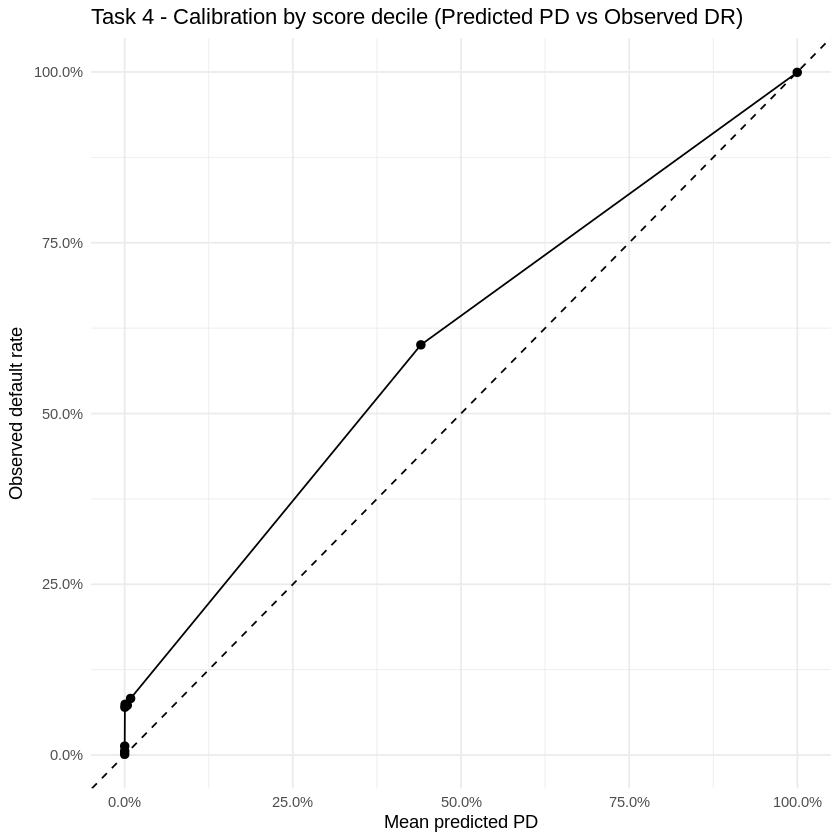

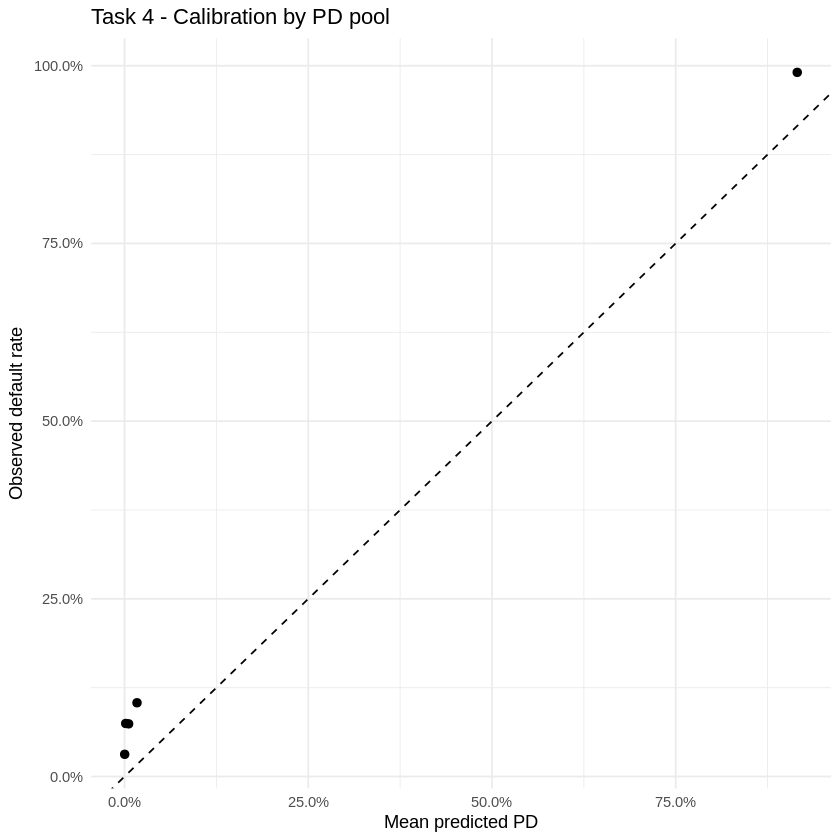

In [ ]:
ggplot(cal_decile, aes(x = mean_pd, y = obs_dr)) +
  geom_point(size = 2) +
  geom_line() +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
  scale_x_continuous(labels = percent_format(accuracy = 0.1)) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 4 - Calibration by score decile (Predicted PD vs Observed DR)",
    x = "Mean predicted PD",
    y = "Observed default rate"
  ) +
  theme_minimal()

cal_pool <- abt_cmp %>%
  group_by(pd_pool) %>%
  summarise(
    n = n(),
    mean_pd = mean(.data[[score_col]], na.rm = TRUE),
    obs_dr = mean(dflt_flag, na.rm = TRUE),
    .groups = "drop"
  )

cat("\n Task 4 / Calibration by PD pool\n")
print(cal_pool)

ggplot(cal_pool, aes(x = mean_pd, y = obs_dr, label = pd_pool)) +
  geom_point(size = 2) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
  scale_x_continuous(labels = percent_format(accuracy = 0.1)) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 4 - Calibration by PD pool",
    x = "Mean predicted PD",
    y = "Observed default rate"
  ) +
  theme_minimal()

The calibration results by Probability of Default (PD) pool confirm that the model separates broad risk groups, but calibration is uneven. The mean predicted PD increases monotonically from Pool 1 to Pool 5, and the observed default rate also generally rises, which indicates that the pool structure is directionally meaningful. However, in Pools 1–4 the observed default rates are consistently higher than the corresponding mean predicted PDs, showing systematic underprediction of risk in the lower and middle segments. Pool 5 is the only group where predicted and observed risk are relatively close, with both values being very high. Overall, the model appears to have good ranking ability across pools, but weak calibration, especially outside the highest-risk group.

**Conclusions Task 4(a)**

From the perspective of sufficiency and accuracy, the model appears useful but not fully well-calibrated. The Brier score is 0.0516, which indicates acceptable overall probability accuracy in aggregate. However, the average predicted PD (14.6%) is lower than the observed default rate (19.9%), which means that the model underpredicts portfolio-level default risk on average.

This conclusion is reinforced by the calibration checks. In the score-decile analysis, the observed default rate generally increases across deciles, but in many deciles it is materially higher than the corresponding mean predicted PD, especially in the middle and upper-middle parts of the score distribution. This indicates systematic underprediction across a substantial part of the portfolio. A similar pattern appears in the PD-pool analysis: the observed default rate is consistently above the mean predicted PD in Pools 1–4, while only Pool 5 shows relatively close alignment between predicted and observed risk.

Therefore, the PD estimates are informative, but their probability level is not fully sufficient in a calibration sense. The model tends to be too conservative in the lower and middle risk segments and underestimates realised default frequency overall.

***Task 4 (b)***

*Measure PD model performance in terms of risk differentiation on risk attribute raw PD estimate levels*

In [ ]:
cat("\n Task 4 / Overall model performance\n")
print(overall_perf)


 Task 4 / Overall model performance
# A tibble: 1 × 6
      n default_rate avg_pd   auc  brier    ks
  <int>        <dbl>  <dbl> <dbl>  <dbl> <dbl>
1 36000        0.199  0.146 0.930 0.0516 0.777


From the perspective of risk differentiation, the model performs strongly. The Area Under the Receiver Operating Characteristic Curve (AUC) equals 0.930, which indicates that the model ranks defaulted and non-defaulted observations very well. The Kolmogorov–Smirnov (KS) statistic of 0.777 also shows strong separation between the score distributions of defaulters and non-defaulters. These results suggest that the model is effective at assigning higher predicted Probability of Default (PD) values to riskier observations and therefore has good discriminatory power.

In [ ]:
cat("\n Task 4 / Calibration by PD pool\n")
print(cal_pool)


 Task 4 / Calibration by PD pool
# A tibble: 6 × 4
  pd_pool     n    mean_pd obs_dr
  <chr>   <int>      <dbl>  <dbl>
1 1       16784   0.000168 0.0312
2 2        5172   0.00158  0.0746
3 3        4724   0.00551  0.0741
4 4        2940   0.0169   0.104 
5 5        5485   0.915    0.991 
6 NA        895 NaN        0.191 


The PD pool summary shows that the model differentiates risk well across broad segments. Both the mean predicted PD and the observed default rate increase from Pool 1 to Pool 5, which means that higher-risk pools correspond to substantially riskier observations. This supports the conclusion that the model has good discriminatory power at the pool level.

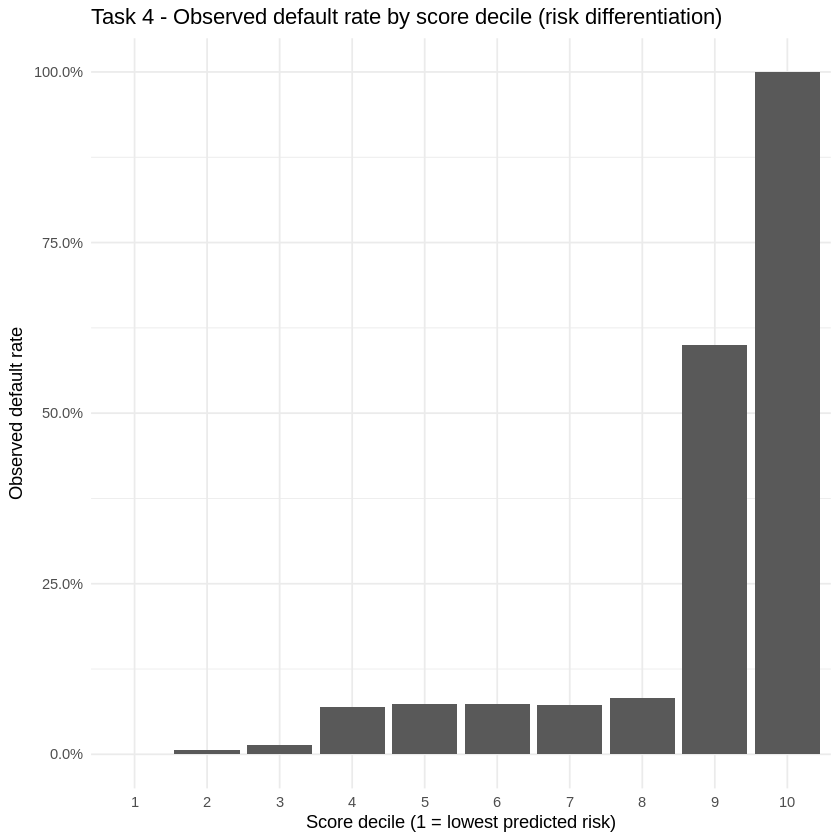

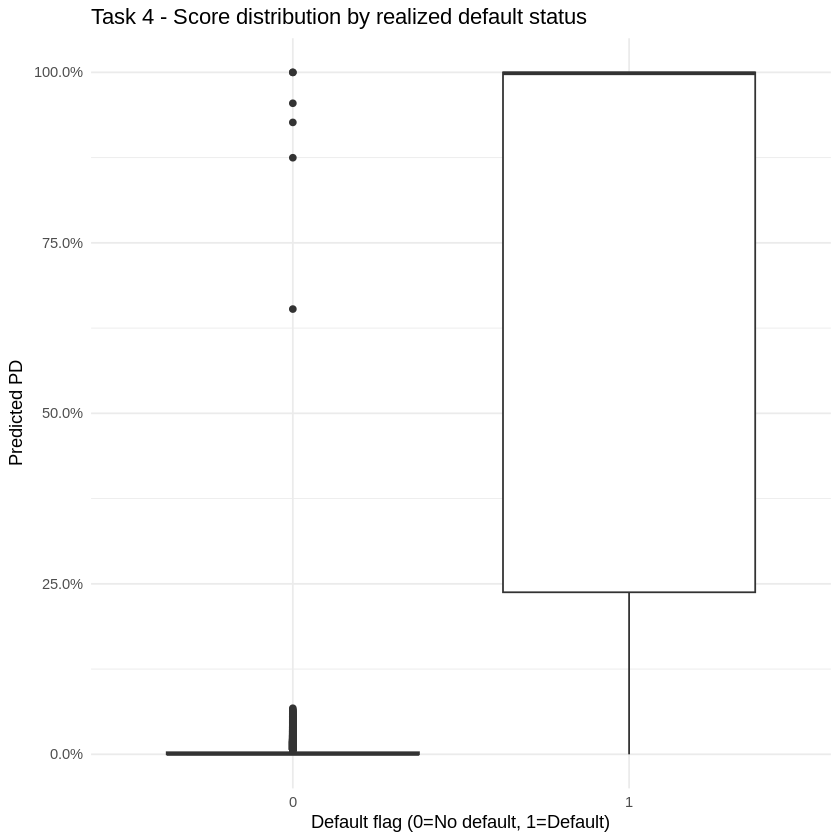

In [ ]:
ggplot(cal_decile, aes(x = factor(score_decile), y = obs_dr)) +
  geom_col() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 4 - Observed default rate by score decile (risk differentiation)",
    x = "Score decile (1 = lowest predicted risk)",
    y = "Observed default rate"
  ) +
  theme_minimal()

ggplot(abt_cmp %>% filter(!is.na(.data[[score_col]]), !is.na(dflt_flag)),
       aes(x = factor(dflt_flag), y = .data[[score_col]])) +
  geom_boxplot() +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 4 - Score distribution by realized default status",
    x = "Default flag (0=No default, 1=Default)",
    y = "Predicted PD"
  ) +
  theme_minimal()

The risk differentiation plots show that the model has strong ranking power. The observed default rate increases sharply across score deciles, especially in the highest deciles, which means that observations with higher predicted PDs are indeed associated with much higher realised default frequency. The boxplot confirms this pattern: the distribution of predicted PD is clearly much higher for the defaulted group than for the non-defaulted group. Overall, these results are consistent with the high AUC and KS statistic, and indicate that the model is good at risk differentiation, even though calibration is weaker.

**Conclusions Task 4(b)**

From the perspective of risk differentiation, the model performs strongly. The Area Under the Receiver Operating Characteristic Curve (AUC) is 0.930, which indicates very good ranking ability, and the Kolmogorov–Smirnov (KS) statistic is 0.777, which shows strong separation between defaulted and non-defaulted observations.

The graphical results confirm this conclusion. The observed default rate rises sharply across score deciles, especially in the highest deciles, which means that higher predicted PD values are indeed associated with much higher realised default frequency. The boxplot of predicted PD by realised default status also shows clear separation: non-defaulted observations are concentrated near very low PD levels, while defaulted observations have a much higher PD distribution. This is exactly the pattern expected from a model with good discriminatory power.

The PD-pool summary supports the same conclusion at the broad segmentation level. Both the mean predicted PD and the observed default rate generally increase from Pool 1 to Pool 5, and the highest-risk pool is clearly the riskiest in both predicted and realised terms. Thus, even though calibration is imperfect, the model is effective at ranking observations from lower to higher risk.

Overall, the PD model has strong discrimination and meaningful risk differentiation, even if the predicted probability levels are not always well calibrated.

***Task 4 (c)***

*Measure PD model stability over time in terms of model coefficients and model result*

I'd like to comute year-by-year results of model performance:

In [ ]:
perf_by_year <- abt_cmp %>%
  group_by(year) %>%
  summarise(
    n = n(),
    default_rate = mean(dflt_flag, na.rm = TRUE),
    avg_pd = mean(.data[[score_col]], na.rm = TRUE),
    auc = auc_manual(dflt_flag, .data[[score_col]]),
    brier = brier_score(dflt_flag, .data[[score_col]]),
    ks = ks_stat(dflt_flag, .data[[score_col]]),
    .groups = "drop"
  )

cat("\n Task 4 / Performance by year\n")
print(perf_by_year)


 Task 4 / Performance by year
# A tibble: 3 × 7
   year     n default_rate avg_pd   auc   brier    ks
  <int> <int>        <dbl>  <dbl> <dbl>   <dbl> <dbl>
1  2022 12000        0.127 0.0826 0.990 0.0319  0.966
2  2023 12000        0.124 0.123  0.986 0.00605 0.952
3  2024 12000        0.346 0.231  0.833 0.117   0.660


The results show that model performance deteriorates materially in 2024. In 2022 and 2023, the model performs very strongly, with AUC close to 1 and KS statistic above 0.95, indicating excellent discrimination. In 2024, however, discrimination weakens noticeably (AUC = 0.833, KS = 0.660) and the Brier score rises sharply to 0.117, which indicates worse probability accuracy. At the same time, the observed default rate increases from about 12% in 2022–2023 to 34.6% in 2024, while the average predicted Probability of Default rises only to 23.1%. This suggests that although the model still captures part of the worsening risk environment, it underpredicts risk and becomes less stable in the most recent year.

Visualizations of year-by-year performance and calibration drift:

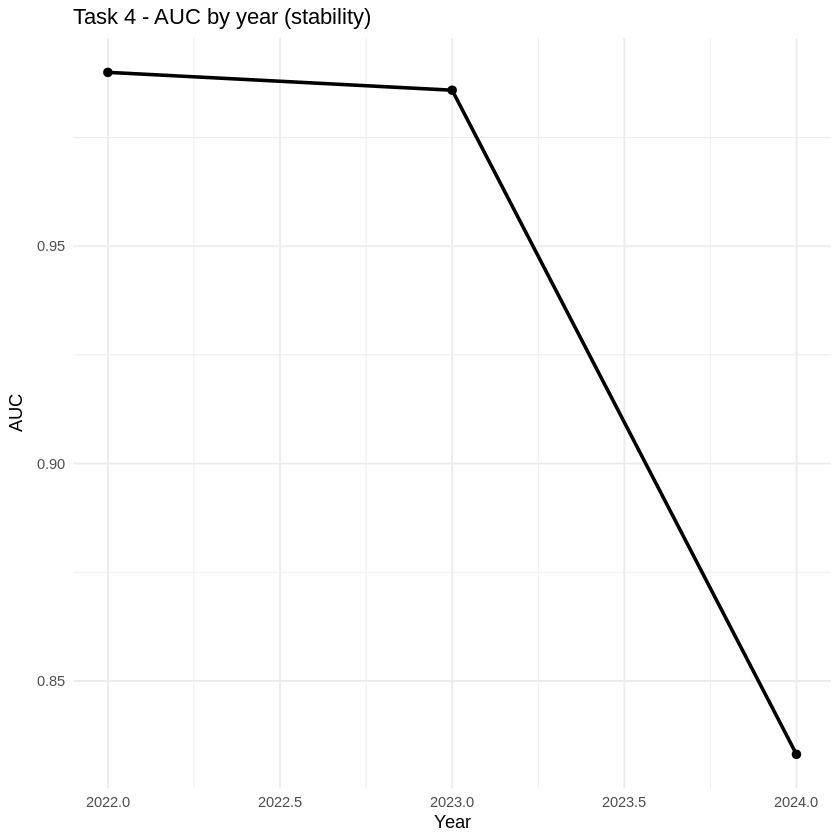

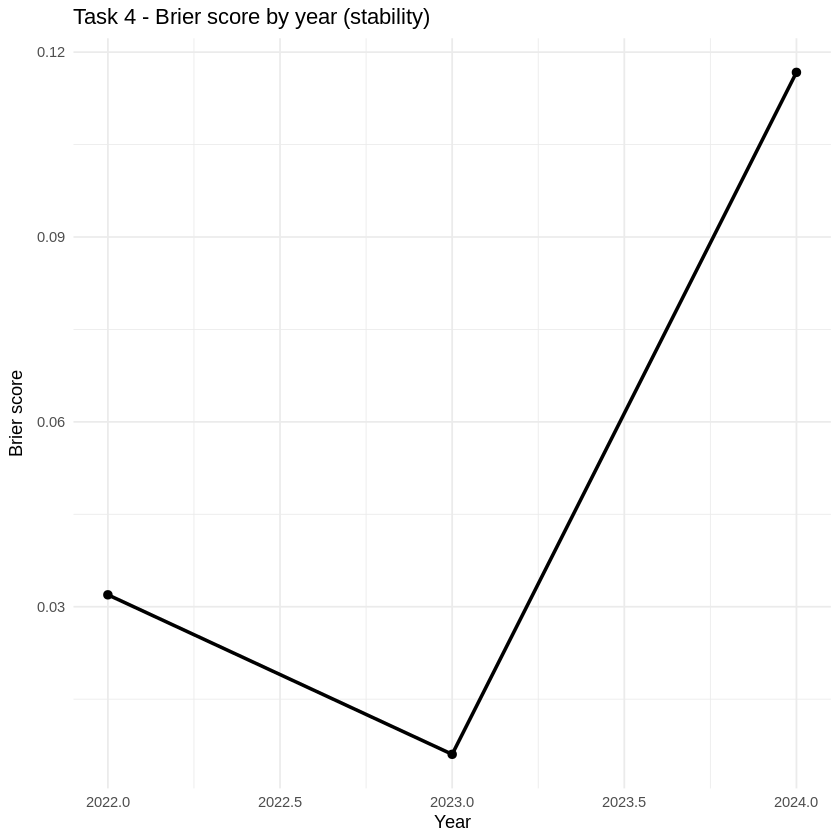

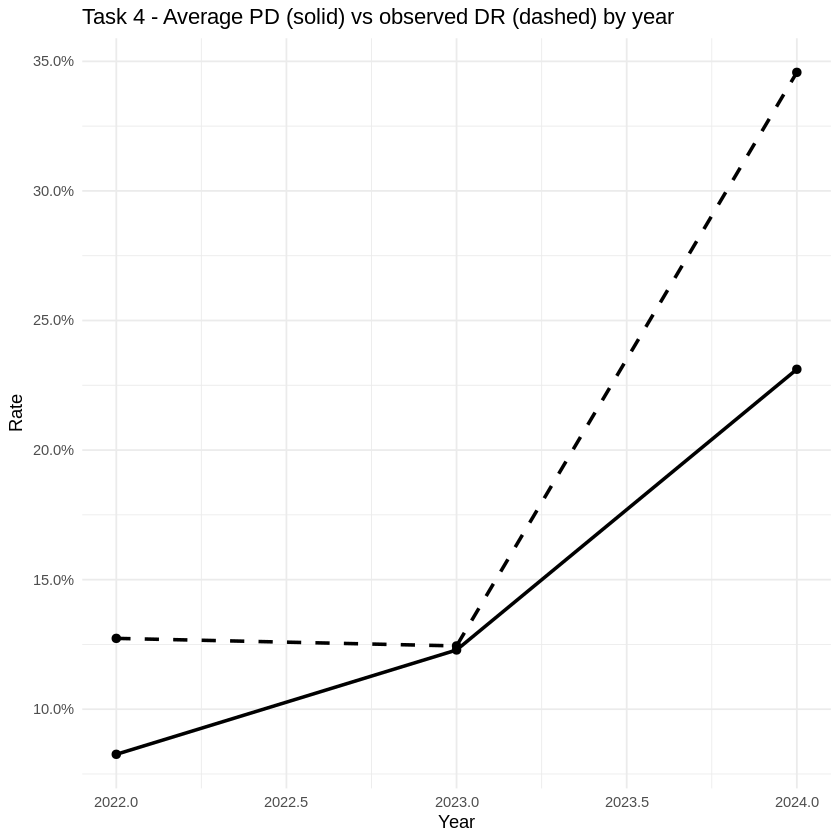

In [ ]:
ggplot(perf_by_year, aes(x = year, y = auc)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  labs(
    title = "Task 4 - AUC by year (stability)",
    x = "Year",
    y = "AUC"
  ) +
  theme_minimal()

ggplot(perf_by_year, aes(x = year, y = brier)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  labs(
    title = "Task 4 - Brier score by year (stability)",
    x = "Year",
    y = "Brier score"
  ) +
  theme_minimal()

ggplot(perf_by_year, aes(x = year)) +
  geom_line(aes(y = avg_pd), linewidth = 1) +
  geom_point(aes(y = avg_pd), size = 2) +
  geom_line(aes(y = default_rate), linewidth = 1, linetype = "dashed") +
  geom_point(aes(y = default_rate), size = 2) +
  scale_y_continuous(labels = percent_format(accuracy = 0.1)) +
  labs(
    title = "Task 4 - Average PD (solid) vs observed DR (dashed) by year",
    x = "Year", y = "Rate"
  ) +
  theme_minimal()

The stability plots confirm that model performance deteriorates in 2024. The Area Under the Receiver Operating Characteristic Curve (AUC) remains very high in 2022–2023 but drops noticeably in 2024, showing weaker discrimination. The Brier score is lowest in 2023 and then increases sharply in 2024, indicating worse probability accuracy. The third plot shows that while the average predicted Probability of Default (PD) rises over time, it remains below the observed default rate in 2024, which suggests a widening calibration gap. Together, these plots indicate that the model is less stable and tends to underpredict risk in the most recent year.

In this next part I define PSI function and calculates PSI vs baseline year.


 Task 4 / PSI vs baseline year
# A tibble: 3 × 2
   year psi_vs_baseline
  <int>           <dbl>
1  2022             0  
2  2023            10.9
3  2024            10.7


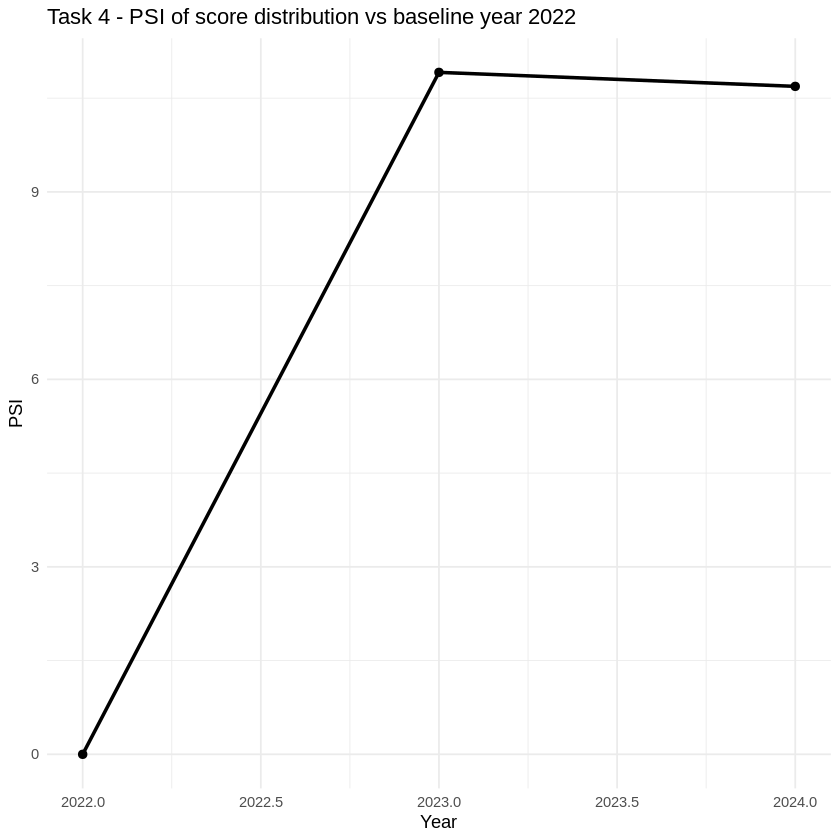

In [ ]:
psi <- function(ref, cur, bins = 10) {
  ref <- ref[is.finite(ref)]
  cur <- cur[is.finite(cur)]

  if (length(ref) == 0 || length(cur) == 0) return(NA_real_)

  brks <- quantile(ref, probs = seq(0, 1, length.out = bins + 1), na.rm = TRUE, names = FALSE)
  brks[1] <- -Inf
  brks[length(brks)] <- Inf

  ref_bin <- cut(ref, breaks = brks, include.lowest = TRUE, right = FALSE)
  cur_bin <- cut(cur, breaks = brks, include.lowest = TRUE, right = FALSE)

  ref_pct <- prop.table(table(ref_bin))
  cur_pct <- prop.table(table(cur_bin))

  all_bins <- union(names(ref_pct), names(cur_pct))
  ref_v <- as.numeric(ref_pct[all_bins]); ref_v[is.na(ref_v)] <- 0
  cur_v <- as.numeric(cur_pct[all_bins]); cur_v[is.na(cur_v)] <- 0

  eps <- 1e-6
  ref_v <- pmax(ref_v, eps)
  cur_v <- pmax(cur_v, eps)

  sum((cur_v - ref_v) * log(cur_v / ref_v))
}

baseline_year <- min(abt_cmp$year, na.rm = TRUE)

ref_scores <- abt_cmp %>%
  filter(year == baseline_year) %>%
  pull(.data[[score_col]])

psi_by_year <- abt_cmp %>%
  group_by(year) %>%
  summarise(
    psi_vs_baseline = psi(ref_scores, .data[[score_col]], bins = 10),
    .groups = "drop"
  )

cat("\n Task 4 / PSI vs baseline year\n")
print(psi_by_year)

ggplot(psi_by_year, aes(x = year, y = psi_vs_baseline)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  labs(
    title = paste0("Task 4 - PSI of score distribution vs baseline year ", baseline_year),
    x = "Year",
    y = "PSI"
  ) +
  theme_minimal()

The Population Stability Index (PSI) results show an extreme shift in score distribution relative to the baseline year 2022. By definition, the PSI for 2022 is 0, while the values for 2023 (10.9) and 2024 (10.7) are extraordinarily high, indicating that the distribution of predicted Probability of Default (PD) changes very strongly compared with the baseline portfolio. This suggests that the score distribution is not stable over time and that the model is being applied to a materially different risk profile in later years. The large PSI values are consistent with the earlier findings of portfolio deterioration and weaker model stability in 2024.

In the end I refit logistic regression by year on transformed variables and track coefficient drift over time.

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



 Task 4 / Optional coefficient drift (refit by year)
# A tibble: 21 × 4
    year term                 estimate std_error
   <int> <chr>                   <dbl>     <dbl>
 1  2022 (Intercept)            6.27      0.623 
 2  2022 age_z                  0.117     0.0492
 3  2022 dr_z                   0.212     0.0411
 4  2022 dpd_z                  1.53      1.68  
 5  2022 mld_z                 -1.41      0.0757
 6  2022 factor(education_m)2   0.0819    0.144 
 7  2022 factor(education_m)3  -0.313     0.117 
 8  2023 (Intercept)           86.7      71.6   
 9  2023 age_z                  0.145     0.0514
10  2023 dr_z                   0.249     0.0404
# ℹ 11 more rows


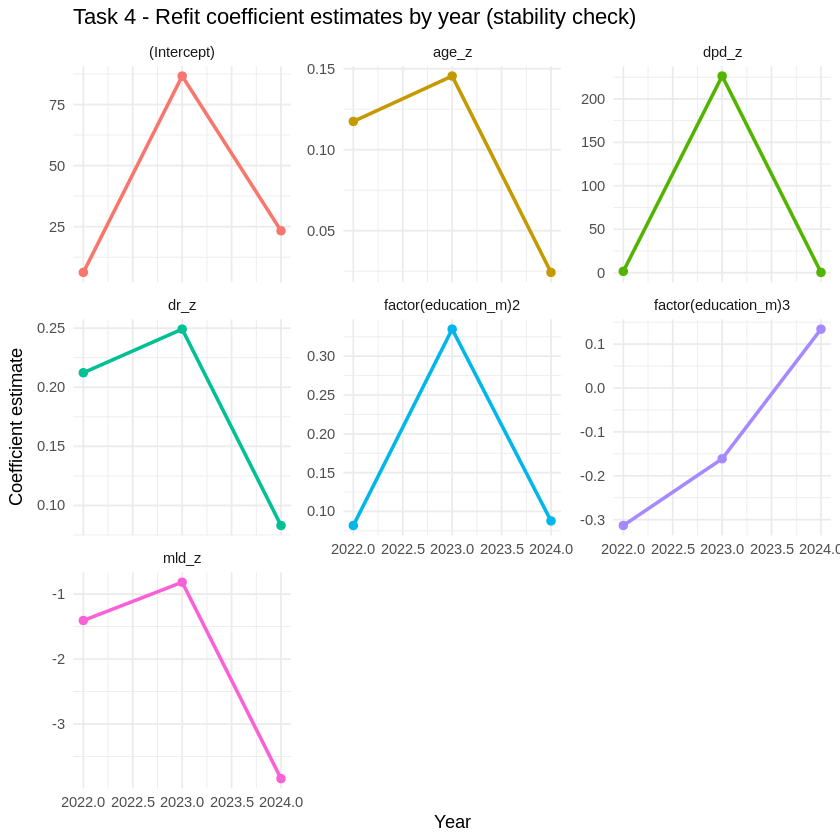

In [ ]:
refit_by_year <- function(df_year) {
  df_year <- df_year %>% filter(!is.na(dflt_flag))
  if (n_distinct(df_year$dflt_flag) < 2) return(NULL)

  fit <- glm(
    dflt_flag ~ age_z + dr_z + dpd_z + mld_z + factor(education_m),
    data = df_year,
    family = binomial()
  )

  cf <- coef(summary(fit))
  tibble(
    term = rownames(cf),
    estimate = cf[, "Estimate"],
    std_error = cf[, "Std. Error"]
  )
}

coef_drift <- abt_cmp %>%
  group_by(year) %>%
  group_modify(~{
    out <- refit_by_year(.x)
    if (is.null(out)) return(tibble())
    out
  }) %>%
  ungroup()

cat("\n Task 4 / Optional coefficient drift (refit by year)\n")
print(coef_drift)

if (nrow(coef_drift) > 0) {
  ggplot(coef_drift, aes(x = year, y = estimate, color = term, group = term)) +
    geom_line(linewidth = 1) +
    geom_point(size = 2) +
    facet_wrap(~term, scales = "free_y") +
    labs(
      title = "Task 4 - Refit coefficient estimates by year (stability check)",
      x = "Year",
      y = "Coefficient estimate"
    ) +
    theme_minimal() +
    theme(legend.position = "none")
}

The optional coefficient-drift analysis suggests that the relationship between the transformed predictors and default is not stable over time. Several refitted coefficients change materially across years, especially the intercept, dpd_z, and mld_z, which indicates that the strength and direction of some risk drivers differ between time periods. This supports the earlier evidence from AUC, Brier score, and PSI that model stability weakens over time, particularly in 2024.

Since the refits also produced warnings about fitted probabilities close to 0 or 1, the results should be interpreted as an exploratory indication of instability rather than a fully robust re-estimation result.

**Conclusions Task 4(c)**

The stability analysis shows that model performance deteriorates materially over time, especially in 2024. In 2022 and 2023, the model is very strong, with AUC values of 0.990 and 0.986 and KS statistics above 0.95, indicating excellent discrimination. In 2024, however, performance weakens substantially: AUC falls to 0.833, KS to 0.660, and the Brier score rises sharply to 0.117, indicating poorer probability accuracy.

At the same time, the difference between predicted and realised risk becomes much larger in 2024. The observed default rate rises to 34.6%, while the average predicted PD increases only to 23.1%. This widening gap indicates deterioration in calibration stability and confirms that the model underpredicts risk in the most recent year.

The Population Stability Index (PSI) provides even stronger evidence of instability. Using 2022 as the baseline year, the PSI is 10.9 in 2023 and 10.7 in 2024, which indicates an extremely large shift in the score distribution relative to the baseline portfolio. This implies that the model is being applied to a materially different risk environment over time.

The optional yearly refit of logistic coefficients points in the same direction. Several coefficients, especially the intercept, dpd_z, and mld_z, vary notably across years, suggesting that the relationship between predictors and default is not constant over time. Because the yearly refits produced warnings about fitted probabilities being numerically 0 or 1, these coefficient results should be interpreted cautiously, but they still support the broader conclusion of instability.

Overall, the model is not stable over time. Its discrimination, probability accuracy, and score distribution all change materially, and the evidence consistently points to a particularly challenging and different environment in 2024.